# Importing all libraries used during this assignment

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import warnings
from countrygroups import EUROPEAN_UNION
from countryinfo import CountryInfo
import glob
import requests
from functools import partial, reduce 
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
import fancyimpute
from scipy.stats import mannwhitneyu

pd.options.mode.use_inf_as_na = True

#managing warnings(ignoring them mostly)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)     
warnings.filterwarnings('ignore')

#setting display options
pd.set_option('display.max_columns', 200)
plt.rcParams['figure.figsize'] = (25, 14)
plt.style.use('seaborn-whitegrid')

from matplotlib.pyplot import cm
color = 'tab20c'

# Introduction to The Project

The brief of this project states that we must focus on the comparison of one irish agricultural sector to similar sectors worldwide. To begin with we will simply start by using data from FAOSTAT to compare the production of dairy products in ireland and other EU countries, after which we will extend our analysis to other countries around the world, such as USA or NZ. A handful of machine learning techniques will be used to make predictions regarding the milk production in these countries, most likely in the units of L/Hectare or L/cow. Throughout this project we will include sentiment analysts so that we may determine if changes in public sentiment reflect the currrent market conditions.

# Importing the Datasets, and building a dataset that we can use for our EDA, statistics, and machine learning

In [2]:
# importing the land data
land_df = pd.read_csv(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\FAOSTAT_Land_Use.csv', on_bad_lines='skip')

# importing dairy products data
dairy_df = pd.read_csv(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\FAOSTAT_DAIRY_DATA.csv', on_bad_lines='skip')

#importing producer price data
price_df = pd.read_csv(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\Producer_milk_prices.csv', on_bad_lines='skip')

#importing export data
export_df = pd.read_csv(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\import_export_prices_v1.csv', on_bad_lines='skip')

#importing manure data
manure_df = pd.read_csv(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\Manure_on_pasture.csv', on_bad_lines='skip')

#importing fertilizer data
fertilizer_df = pd.read_csv(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\Fert_nutrient_agri.csv', on_bad_lines='skip')


#to deal with all of the temp and rain files we will create custom functions that put the year/country, and annual value in 
# a dataframe and then appends it to a list of dataframes. We will then concatenate all of the dataframes in the list into one
# dataframe

#function to process the csv files and get them in the formast we want in the final dataframe
def process(file, col_name):
    df = pd.read_csv(file, on_bad_lines='skip', skiprows=1)
        
    #change NaN column name
    df.rename(columns={'Unnamed: 0': 'Year'}, inplace=True)
    #add acolumn that contains country code in each cell
    df['key'] = df.columns[1] + df['Year'].astype(str)
    df.rename(columns={df.columns[1]: col_name}, inplace=True)
    df = df.filter(['key', col_name] )
    return df

#function to create a dataframe from all of the csv files in a folder, and apply the pre processing steps 
#detailed in the process function
def files_to_df(path, col_name):
    csv_files = glob.glob(path + "/*.csv")
    df_list = (process(filename, col_name) for filename in csv_files)
    df = pd.concat(df_list, ignore_index=True)
    return df

#creating a dataframe for the rain data
rain_df = files_to_df(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\Eu_rain_data', 'Rainfall_mm/yr')
 
#creating a dataframe for the temp data
temp_df = files_to_df(r'C:\Users\faela\OneDrive\Documents\GitHub\MSc-Data-Analytics\CA_2\Eu_temp_data', 'Temperature_C')


# 1) Data Understanding/Preparation

### To kick this project off, we will focus on taking these datasets that we have imported above, and condense them down to a single dataset. We could certainly get away without going through these steps, but doing this now should save us a few headaches somewhere down the line. While we do this we will also encorporate some data preparation by constructing relevant attributes for EDA. This section exists purely to get a rough dataset put together, Eda and final cleaning will be carried out later on.

a) We are using the dairy products dataset as our jumping off point. This contains data related to many different products, but we will be mostly concerned with information related to Raw milk. We will isolate data related to this and use it as a base for the rest of our datasets

In [3]:

# look at the structure of the dairy data
dairy_df.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,QCL,Crops and livestock products,4,Afghanistan,5510,Production,22241.01,Butter of cow milk,1961,1961,tonnes,7000.0,I,Imputed value
1,QCL,Crops and livestock products,4,Afghanistan,5510,Production,22241.01,Butter of cow milk,1962,1962,tonnes,7000.0,I,Imputed value
2,QCL,Crops and livestock products,4,Afghanistan,5510,Production,22241.01,Butter of cow milk,1963,1963,tonnes,8000.0,I,Imputed value
3,QCL,Crops and livestock products,4,Afghanistan,5510,Production,22241.01,Butter of cow milk,1964,1964,tonnes,8000.0,I,Imputed value
4,QCL,Crops and livestock products,4,Afghanistan,5510,Production,22241.01,Butter of cow milk,1965,1965,tonnes,9000.0,I,Imputed value


Okay, it looks like there are some years where the values for dairy products were not recorded. We will first look at the years present & the items for which data is available.

In [4]:
#find unique of dairy items in the dataset, and filter only the ones we want to see
print(dairy_df['Item'].unique())
items = ['Raw milk of cattle']

['Butter of cow milk' 'Cattle' 'Raw milk of cattle' 'Skim milk of cows'
 'Cheese from whole cow milk' 'Cheese from skimmed cow milk'
 'Skim milk and whey powder' 'Buttermilk, dry']


In [5]:
# what are the unique year values?
dairy_df['Year'].unique()

array([1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971,
       1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,
       2016, 2017, 2018, 2019, 2020], dtype=int64)

In [6]:
#filtering the data to only include the EU member states and items of interest
#at this stage i wont make a function to do this as we want this whole df as a base
#this process will be carried out often so we will make a function for it later
milk_eu_head = dairy_df[(dairy_df['Area'].isin(EUROPEAN_UNION.names)) & (dairy_df['Item'].isin(items)) & (dairy_df['Unit'] == 'Head')]#filtering the data to only include the EU member states and head of cattle
milk_eu_head['key'] = milk_eu_head['Area'] + milk_eu_head['Year'].astype(str)# creating a key column to merge the two datasets
milk_eu_tonne = dairy_df[(dairy_df['Area'].isin(EUROPEAN_UNION.names)) & (dairy_df['Item'].isin(items)) & (dairy_df['Unit'] == 'tonnes')]#filtering the data to only include the EU member states and tonnes of milk
milk_eu_tonne['key'] = milk_eu_tonne['Area'] + milk_eu_tonne['Year'].astype(str)# creating a key column to merge the two datasets

#merging the two datasets to get the total milk production in tonnes and the number of cows in one dataset
milk_eu = pd.merge(milk_eu_head, milk_eu_tonne[['key','Unit', 'Value']], on='key', how='left')#
milk_eu.drop(['Unit_x', 'Unit_y'], axis=1, inplace=True)#dropping the unit columns
milk_eu.rename(columns={'Value_x':'Head', 'Value_y':'Tonne'}, inplace=True)#renaming the value columns
milk_eu[(milk_eu['Area'] == 'Italy') & (milk_eu['Year'] == 2000)]

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Head,Flag,Flag Description,key,Tonne
746,QCL,Crops and livestock products,380,Italy,5318,Milk Animals,2211.0,Raw milk of cattle,2000,2000,2126000.0,A,Official figure,Italy2000,12309400.0


### b) Lets take a while to look at the Land use data now.

In [7]:
land_df.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code,Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,RL,Land Use,4,Afghanistan,5110,Area,6633,Land under temp. meadows and pastures,2001,2001,1000 ha,0.0,I,Imputed value
1,RL,Land Use,4,Afghanistan,5110,Area,6633,Land under temp. meadows and pastures,2002,2002,1000 ha,0.0,I,Imputed value
2,RL,Land Use,4,Afghanistan,5110,Area,6633,Land under temp. meadows and pastures,2003,2003,1000 ha,0.0,I,Imputed value
3,RL,Land Use,4,Afghanistan,5110,Area,6633,Land under temp. meadows and pastures,2004,2004,1000 ha,0.0,I,Imputed value
4,RL,Land Use,4,Afghanistan,5110,Area,6633,Land under temp. meadows and pastures,2005,2005,1000 ha,0.0,I,Imputed value


 Having looked at this data we can see that the land usage for temporary pastures & perminant pastures are given in a single column. We will first splot these into separate columns and add these together to get an idea of the TOTAL pasture area. To do this we will create two separate dataframes and merge them. Since looking at items individually and marging them will be a common theme, we will make a function to do this on our behalf. You could use pd.pivot() here, however im not a fan of how this leaves the dataframe formatting, so i would rather go this route. It also provides a greater degree of flexibility

In [8]:
#first we will make a list of the countries of interest
countries = milk_eu['Area'].unique().tolist()

##now we define our column value splitting function
def reformat(dataframe, column):
    container = {} #create an empty dictionary to store the dataframes
    for i in dataframe[column].unique(): #loop through the unique values in the column of interest
        container[f'{i}'] = dataframe[(dataframe[column] == i) & (dataframe['Area'].isin(countries))] #create a dataframe for each unique value in the column of interest
        container[f'{i}']['key'] = container[f'{i}']['Area'] + container[f'{i}']['Year'].astype(str)   #create a key column to merge the dataframes later

    for i in container: #loop through dataframes in the dict and apply some conditions
        container[i] = container[i][['key', 'Area', 'Value']]#filter the dataframes to only include the key, area and value columns
        container[i].rename(columns={'Value': f'{i}'}, inplace=True)#rename the value column to the name of the item


    my_reduce = partial(pd.merge, on=['key', 'Area'], how='right')  #create a function to merge the dataframes in the dict                                                           
    df =  reduce(my_reduce, container.values()) #calling that function on the values in the dict
    return df

#calling the function on the land data
total_pasture = reformat(land_df, 'Item')
#replace NaN with 0 in the temporary pasture column, /i am taking nan values to indicate an absence of that type of pasture
total_pasture['Land under temp. meadows and pastures'].fillna(0, inplace=True)

#merge the total pasture data with the milk data
milk_eu = pd.merge(milk_eu, total_pasture, on=['key', 'Area'], how='left')
milk_eu[(milk_eu['Area'] == 'Italy') & (milk_eu['Year'] == 2000)]


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Head,Flag,Flag Description,key,Tonne,Land under temp. meadows and pastures,Land under perm. meadows and pastures
746,QCL,Crops and livestock products,380,Italy,5318,Milk Animals,2211.0,Raw milk of cattle,2000,2000,2126000.0,A,Official figure,Italy2000,12309400.0,0.0,4353.0


### c) Now lets look at how much a farmer gets paid for she milk s/he produces. This may be an important indicator for predicting the milk production or productivity in the future. It will certainly be a great thing to have for data analysis on the topic.

In [9]:
price_df.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Months Code,Months,Unit,Value,Flag,Flag Description
0,PP,Producer Prices,40,Austria,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,1991,1991,7021,Annual value,USD,454.8,A,Official figure
1,PP,Producer Prices,40,Austria,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,1992,1992,7021,Annual value,USD,499.6,A,Official figure
2,PP,Producer Prices,40,Austria,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,1993,1993,7021,Annual value,USD,468.6,A,Official figure
3,PP,Producer Prices,40,Austria,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,1994,1994,7021,Annual value,USD,478.9,A,Official figure
4,PP,Producer Prices,40,Austria,5532,Producer Price (USD/tonne),2211,Raw milk of cattle,1995,1995,7021,Annual value,USD,372.9,A,Official figure


In [10]:
price_df.Year.unique()

array([1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [11]:
#we want to filter the dataframe by countries, making sure that we only have eu member states
price_df = price_df[price_df['Area'].isin(countries)]
#filter the Months column to show only annual value
price_df = price_df[price_df['Months'] == 'Annual value']
#make a key column to merge the data
price_df['key'] = price_df['Area'] + price_df['Year'].astype(str)
#merge the data onto the milk_euy dataframe
milk_eu = pd.merge(milk_eu, price_df[['key', 'Value']], on='key', how='left')
#since prices are only recorded after 1990 we will filter the years
milk_eu = milk_eu[milk_eu['Year'] > 1990]
milk_eu.shape

(783, 18)

### d) almost there for the dataset construction. We will now look at the quantity of milk exported from the countries

In [12]:
print(milk_eu.shape)
#reformat the dataframe using our lovely function
export_info_df = reformat(export_df, 'Element')
#and simply merge this onto ourt milk_eu dataframe
milk_eu = pd.merge(milk_eu, export_info_df[['key', 'Export Value', 'Export Quantity']], on='key', how = 'left')
milk_eu[(milk_eu['Area'] == 'Italy') & (milk_eu['Year'] == 2000)]

(783, 18)


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Head,Flag,Flag Description,key,Tonne,Land under temp. meadows and pastures,Land under perm. meadows and pastures,Value,Export Value,Export Quantity
416,QCL,Crops and livestock products,380,Italy,5318,Milk Animals,2211.0,Raw milk of cattle,2000,2000,2126000.0,A,Official figure,Italy2000,12309400.0,0.0,4353.0,NaN,6804.0,11797.0


### e) Append the temperature and rain data to the milk_eu dataframe

In [13]:
temp_df.head()

,key,Temperature_C
0,Austria1901,5.41
1,Austria1902,5.34
2,Austria1903,5.88
3,Austria1904,6.22
4,Austria1905,5.79


In [14]:
rain_df.head()

,key,Rainfall_mm/yr
0,Austria1901,1052.84
1,Austria1902,1061.55
2,Austria1903,1201.34
3,Austria1904,1146.14
4,Austria1905,1127.85


In [15]:

milk_eu = pd.merge(milk_eu, temp_df, on='key', how='left')
milk_eu = pd.merge(milk_eu, rain_df, on='key', how='left')
milk_eu[(milk_eu['Area'] == 'Italy') & (milk_eu['Year'] == 2000)]

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Head,Flag,Flag Description,key,Tonne,Land under temp. meadows and pastures,Land under perm. meadows and pastures,Value,Export Value,Export Quantity,Temperature_C,Rainfall_mm/yr
416,QCL,Crops and livestock products,380,Italy,5318,Milk Animals,2211.0,Raw milk of cattle,2000,2000,2126000.0,A,Official figure,Italy2000,12309400.0,0.0,4353.0,NaN,6804.0,11797.0,13.37,802.66


### f) Last part of the dataset construction, lets get this shit sorted... were looking at manure and fertiliser used for pasture land.

In [16]:
manure_df.head()

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description
0,EMN,Livestock Manure,4,Afghanistan,72380,Manure left on pasture (N content),F0960,"Cattle, dairy",1961,1961,kg,1.733727e+07,E,Estimated value
1,EMN,Livestock Manure,4,Afghanistan,72380,Manure left on pasture (N content),F0960,"Cattle, dairy",1962,1962,kg,1.733727e+07,E,Estimated value
2,EMN,Livestock Manure,4,Afghanistan,72380,Manure left on pasture (N content),F0960,"Cattle, dairy",1963,1963,kg,1.931867e+07,E,Estimated value
3,EMN,Livestock Manure,4,Afghanistan,72380,Manure left on pasture (N content),F0960,"Cattle, dairy",1964,1964,kg,1.931867e+07,E,Estimated value
4,EMN,Livestock Manure,4,Afghanistan,72380,Manure left on pasture (N content),F0960,"Cattle, dairy",1965,1965,kg,2.154775e+07,E,Estimated value


In [17]:
#filter the dataframe for only eu memberstate countries
manure_df = manure_df[manure_df['Area'].isin(countries)]
#create a key column to merge the data
manure_df['key'] = manure_df['Area'] + manure_df['Year'].astype(str)
#rename the value column to manure_kg
manure_df.rename(columns={'Value': 'Manure_kg'}, inplace=True)
#merge the data onto the milk_eu dataframe
milk_eu = pd.merge(milk_eu, manure_df[['key', 'Manure_kg']], on='key', how = 'left')

In [18]:
fert_df = reformat(fertilizer_df, 'Item')
milk_eu = pd.merge(milk_eu, fert_df, on=['key', 'Area'], how = 'left')
milk_eu[(milk_eu['Area'] == 'Italy') & (milk_eu['Year'] == 2000)]

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Head,Flag,Flag Description,key,Tonne,Land under temp. meadows and pastures,Land under perm. meadows and pastures,Value,Export Value,Export Quantity,Temperature_C,Rainfall_mm/yr,Manure_kg,Nutrient nitrogen N (total),Nutrient phosphate P2O5 (total),Nutrient potash K2O (total)
416,QCL,Crops and livestock products,380,Italy,5318,Milk Animals,2211.0,Raw milk of cattle,2000,2000,2126000.0,A,Official figure,Italy2000,12309400.0,0.0,4353.0,NaN,6804.0,11797.0,13.37,802.66,44697024.0,828000.0,504000.0,400000.0


In [19]:
milk_eu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783 entries, 0 to 782
Data columns (total 26 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Domain Code                            783 non-null    object 
 1   Domain                                 783 non-null    object 
 2   Area Code (M49)                        783 non-null    int64  
 3   Area                                   783 non-null    object 
 4   Element Code                           783 non-null    int64  
 5   Element                                783 non-null    object 
 6   Item Code (CPC)                        783 non-null    float64
 7   Item                                   783 non-null    object 
 8   Year Code                              783 non-null    int64  
 9   Year                                   783 non-null    int64  
 10  Head                                   783 non-null    float64
 11  Flag  

<AxesSubplot:>

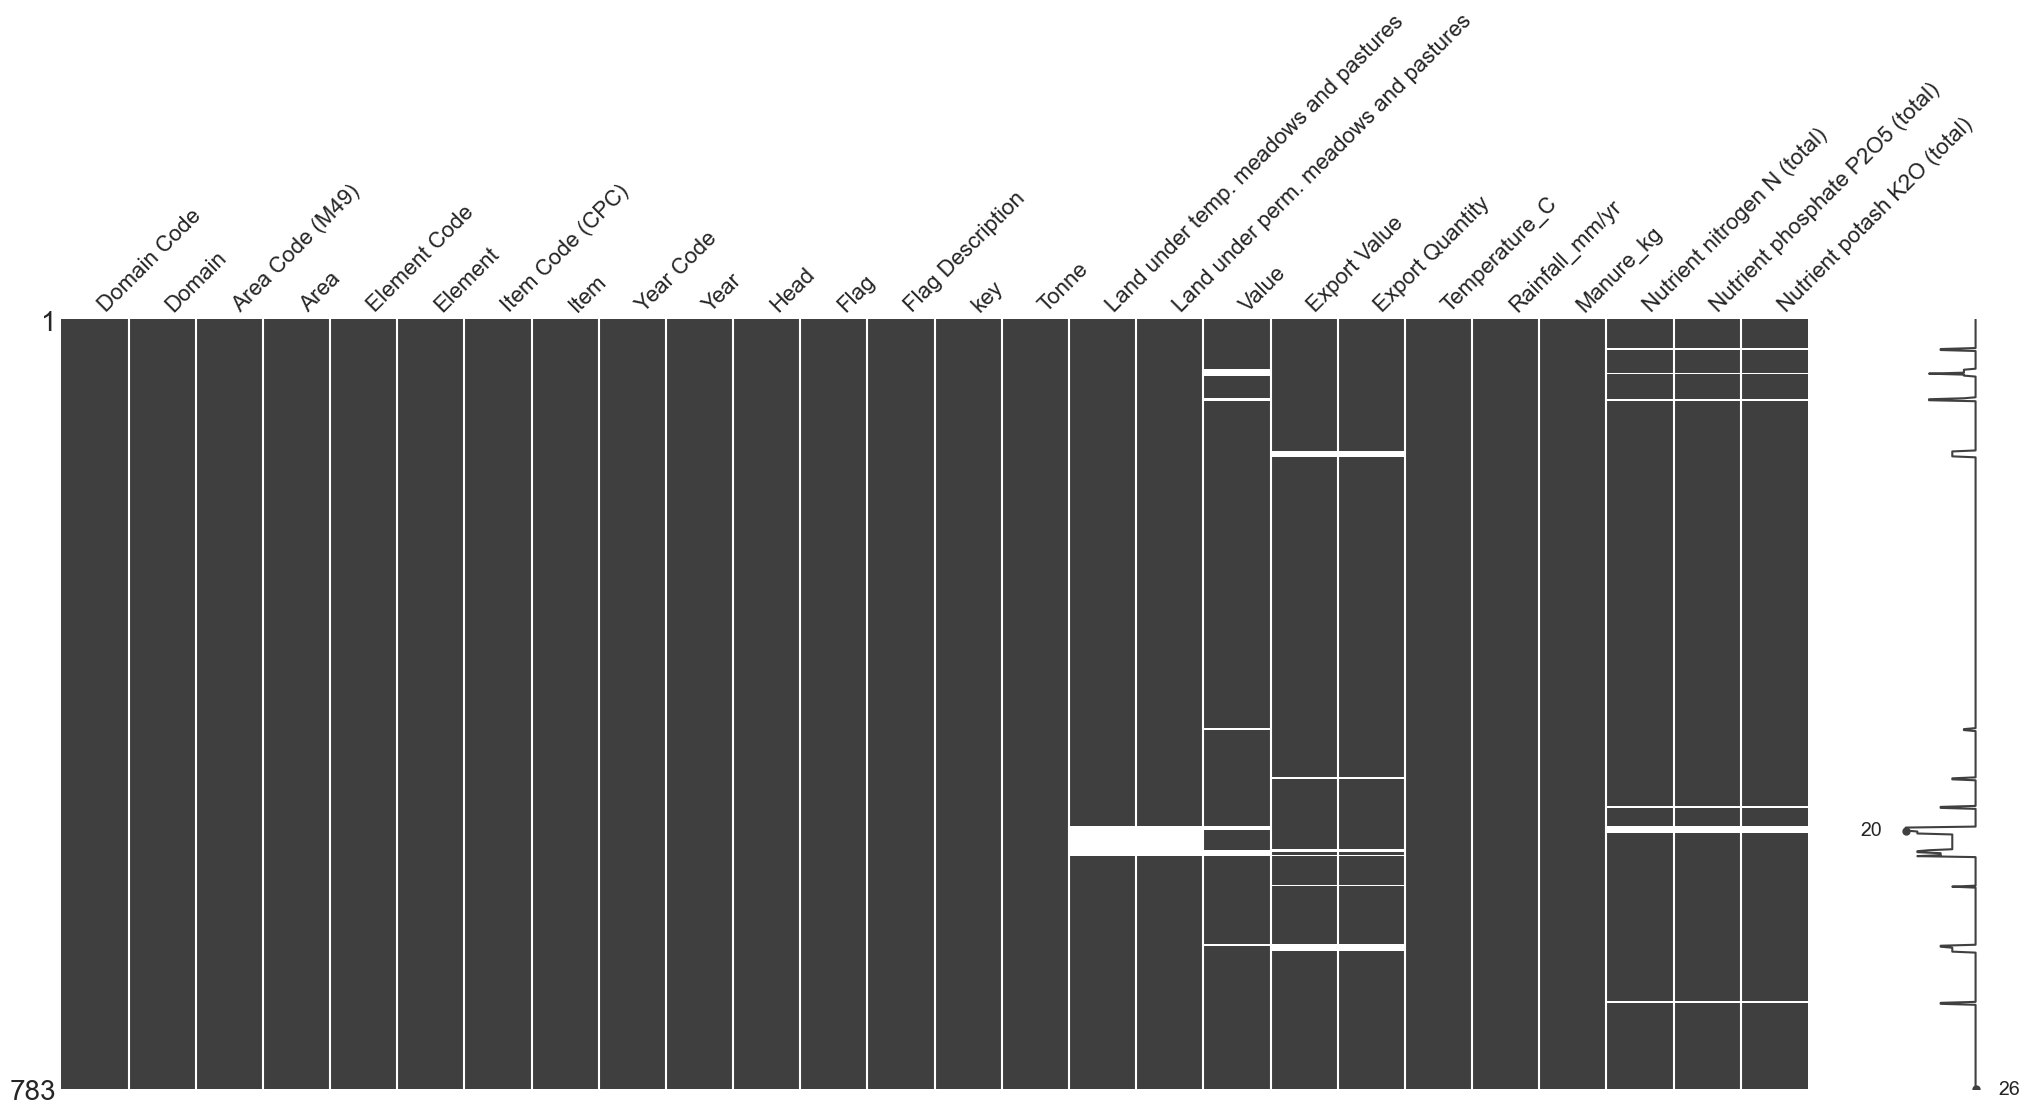

In [20]:
msno.matrix(milk_eu)

Theres a few things we will need to look at before moving forward here
* Missing values in the meadows and pastures data
* Misssing values in the Exports Data
* Missing values in the fertilizer data

I will address these in the following section & determine the best approach on a case by case basis.

# 2) Data cleaning & feature engineering stage

Lets kick things off by building a function that will loop over many imputation techniques and will compare their results, spitting out the best one. 

In [21]:
#dropping redundant columns
milk_eu.drop(['Domain Code', 'Domain', 'Area Code (M49)',
 'Element Code', 'Element', 'Item Code (CPC)', 'Item', 'Year Code', 'Flag', 'key', 'Flag Description'], axis=1, inplace=True)

In [22]:
from scipy.stats import ks_2samp
def impute_data(milk_eu, columns, k, iter, model, target):
    #defining the imputation methods
    imputation_type = ['.mean()', '.mode()', '.median()','bfill', 'ffill', 'knn', 'mice']
    #dropping null columns and making nan values are np.nan format
    milk_eu_imp = milk_eu.fillna(np.nan).drop(columns, axis=1).select_dtypes(exclude=['object'])

    results = {}#creating a dictionary to store the results
    best = {}#creating a dictionary to store the best results

    #defining the mannwhitneyu test
    def score_dataset(milk_eu, impute):
        u, p = ks_2samp(milk_eu.dropna(), impute)
        return p #returning the p value

    #looping through the columns to be imputed
    for col in columns:

        #defining the imputation methods in a dictionary to allow iteration
        #this is done to avoid having to write out each method individually
        functions = {
        'mean': milk_eu[col].mean(),
        'mode': milk_eu[col].mode(),
        'median': milk_eu[col].median(),
        'bfill': milk_eu[col].fillna(method='bfill'),
        'ffill': milk_eu[col].fillna(method='ffill')
    }

        #looping through the imputation methods
        for type in imputation_type:

            if type in functions:#if the imputation method is in the dictionary
                impute = functions[type]
                results[f'{type}_{col}'] = score_dataset(milk_eu[col], impute)#adding the results to the results dictionary

            elif type == 'knn':#if the imputation method is knn
                for i in k:#looping through the k values
                    milk_eu_imp[col] = milk_eu[col].fillna(np.nan)
                    impute = pd.DataFrame(fancyimpute.KNN(k=i, verbose=False).fit_transform(milk_eu_imp))
                    impute.columns = milk_eu_imp.columns #setting the column names to the original column names
                    results[f'{type}_{col}'] = score_dataset(milk_eu[col], impute[col])#adding the results to the results dictionary

            elif type == 'mice':#if the imputation method is mice
                for iterations in iter:#looping through the iterations
                    milk_eu_imp[col] = milk_eu[col].fillna(np.nan)
                    imputed = pd.DataFrame(fancyimpute.IterativeImputer(max_iter=iterations).fit_transform(milk_eu_imp))
                    impute.columns = milk_eu_imp.columns #setting the column names to the original column names
                    results[f'{type}_{col}'] = score_dataset(milk_eu[col], impute[col]) #adding the results to the results dictionary 

        #put max value in 'best' dict, this returrns the best imputation method
        best[col] = max(results, key=results.get)
        
    return best, results

In [23]:
milk_eu.isna().sum()

Area                                      0
Year                                      0
Head                                      0
Tonne                                     0
Land under temp. meadows and pastures    30
Land under perm. meadows and pastures    30
Value                                    24
Export Value                             20
Export Quantity                          20
Temperature_C                             0
Rainfall_mm/yr                            0
Manure_kg                                 0
Nutrient nitrogen N (total)              16
Nutrient phosphate P2O5 (total)          16
Nutrient potash K2O (total)              16
dtype: int64

### a) First we will deal with the missing values using the method constructed above

In [24]:
#defining the function inputs
columns = [i for i in milk_eu.columns if milk_eu[i].isnull().any()] #columns containing null values
k = [1, 3, 5, 7, 9, 11] #number of neighbours for knn imputation
iter = [20, 40, 60, 80, 100, 120] #number of iterations for mice imputation

#calling the function
best_imp, results_imp = impute_data(milk_eu, columns, k, iter, KNeighborsRegressor(), 'Tonne')

In [25]:
best_imp

{'Land under temp. meadows and pastures': 'ffill_Land under temp. meadows and pastures',
 'Land under perm. meadows and pastures': 'bfill_Land under perm. meadows and pastures',
 'Value': 'knn_Value',
 'Export Value': 'knn_Value',
 'Export Quantity': 'knn_Value',
 'Nutrient nitrogen N (total)': 'knn_Value',
 'Nutrient phosphate P2O5 (total)': 'knn_Value',
 'Nutrient potash K2O (total)': 'knn_Value'}

In [26]:
results_imp

{'bfill_Land under temp. meadows and pastures': 0.9763074856261597,
 'ffill_Land under temp. meadows and pastures': 0.987699161731823,
 'knn_Land under temp. meadows and pastures': 0.9860945202912247,
 'mice_Land under temp. meadows and pastures': 0.9860945202912247,
 'bfill_Land under perm. meadows and pastures': 0.9935989841828134,
 'ffill_Land under perm. meadows and pastures': 0.7337173791662438,
 'knn_Land under perm. meadows and pastures': 0.7072926274732465,
 'mice_Land under perm. meadows and pastures': 0.7072926274732465,
 'bfill_Value': 0.9999999998322696,
 'ffill_Value': 0.9999999999564412,
 'knn_Value': 0.9999999999999999,
 'mice_Value': 0.9999999999999999,
 'bfill_Export Value': 0.9997237240490395,
 'ffill_Export Value': 0.9999999966552022,
 'knn_Export Value': 0.9999999999999997,
 'mice_Export Value': 0.9999999999999997,
 'bfill_Export Quantity': 0.9999131422140595,
 'ffill_Export Quantity': 0.9999999908905691,
 'knn_Export Quantity': 0.999999999999999,
 'mice_Export Quan

It appears as though the best imputation method for most of our columns is the forward filling method. This is great for us as it really speeeds up imputing the data, we will do this below.

In [27]:
#splitting columns into lists for impuation methods
ffill = []
bfill = []
for i in columns:
    if i == 'Land under perm. meadows and pastures':
        bfill.append(i)

    else:
        ffill.append(i)

#imputing the data
milk_eu[ffill] = milk_eu[ffill].fillna(method = 'ffill')
milk_eu[bfill] = milk_eu[bfill].fillna(method = 'bfill')



In [28]:
milk_eu.isnull().sum()

Area                                     0
Year                                     0
Head                                     0
Tonne                                    0
Land under temp. meadows and pastures    0
Land under perm. meadows and pastures    0
Value                                    0
Export Value                             0
Export Quantity                          0
Temperature_C                            0
Rainfall_mm/yr                           0
Manure_kg                                0
Nutrient nitrogen N (total)              0
Nutrient phosphate P2O5 (total)          0
Nutrient potash K2O (total)              0
dtype: int64

In [29]:
milk_eu.describe()

,Year,Head,Tonne,Land under temp. meadows and pastures,Land under perm. meadows and pastures,Value,Export Value,Export Quantity,Temperature_C,Rainfall_mm/yr,Manure_kg,Nutrient nitrogen N (total),Nutrient phosphate P2O5 (total),Nutrient potash K2O (total)
count,783.000000,7.830000e+02,7.830000e+02,783.000000,783.000000,783.000000,7.830000e+02,7.830000e+02,783.000000,783.000000,7.830000e+02,7.830000e+02,7.830000e+02,7.830000e+02
mean,2005.905492,9.237232e+05,5.225249e+06,347.294250,2248.023984,369.797829,9.862057e+04,2.052257e+05,10.453755,774.282388,1.762689e+07,3.849413e+05,1.160936e+05,1.267529e+05
std,8.508534,1.198630e+06,7.179461e+06,720.630026,2798.355962,118.457542,1.808037e+05,3.742659e+05,3.973331,241.525639,2.402044e+07,5.362020e+05,1.802707e+05,2.195068e+05
min,1991.000000,6.000000e+03,3.306100e+04,0.000000,1.000000,39.200000,0.000000e+00,0.000000e+00,0.910000,278.420000,1.261440e+05,4.072000e+02,6.000000e+00,1.300000e+01
25%,1999.000000,2.134515e+05,8.104895e+05,0.000000,456.420000,304.500000,1.160000e+03,3.235500e+03,8.255000,621.215000,3.771227e+06,8.978700e+04,1.897200e+04,1.868750e+04
50%,2006.000000,3.909000e+05,2.447342e+06,33.140000,991.838000,365.600000,2.201200e+04,4.803400e+04,10.120000,719.510000,7.315700e+06,1.831510e+05,4.609200e+04,4.568300e+04
75%,2013.000000,1.195672e+06,5.374900e+06,227.150000,3897.900000,433.750000,1.068040e+05,2.232330e+05,12.330000,867.655000,2.180707e+07,3.596760e+05,1.130000e+05,9.440100e+04
max,2020.000000,5.632000e+06,3.316491e+07,3454.800000,11533.000000,794.300000,1.195006e+06,2.233207e+06,20.350000,1780.040000,1.184072e+08,2.571400e+06,1.255000e+06,1.741000e+06


Great, now that this is done we can move along to some more exciting tasks... Feature engineering & EDA!

b) Feature Engineering - Calculated Columns

In [30]:
milk_eu_eda = milk_eu.copy()

Our first port of call will be to prepare the dataset for plotting a choropleth map. This means that we need the 3 letter code that corresponds to each country in the dataset. Conveniently the pycountry library makes this very easy for us.

In [31]:
#converting country name to country code, this will be needed for the choropleth map
import pycountry
def country_name_to_country_code(country_name):
    country_code = pycountry.countries.search_fuzzy(country_name)[0].alpha_3
    return country_code

#now applying this to the dataframe
milk_eu_eda['Country Code'] = milk_eu_eda['Area'].apply(country_name_to_country_code)

For our investigations it may be beneficial to know the amount of milk exported in terms of volume, specifically litres. To convert tonnes to litres, we simply look back to our beginner physics  class and remember the following formula,

$$ V = \frac{m}{\rho{}} $$
 
where V is volume, m is mass. and  $\rho{}$  is the density. The density for raw milk will be 1.027kg/m3 on average at a temperature of 20c.

nice to finally be making good use of that physics degree...

In [32]:
#function to convert tonnes to litres
def volume(x):
    return x*1000/1.027

milk_eu_eda['volume(litre)'] = milk_eu_eda['Tonne'].apply(volume)#Icould probably have used a lambda function here, but i might use the volume function later so no harm having close to hand
milk_eu_eda['volume/cow(litre)'] = milk_eu_eda['volume(litre)']/milk_eu['Head']
milk_eu_eda

,Area,Year,Head,Tonne,Land under temp. meadows and pastures,Land under perm. meadows and pastures,Value,Export Value,Export Quantity,Temperature_C,Rainfall_mm/yr,Manure_kg,Nutrient nitrogen N (total),Nutrient phosphate P2O5 (total),Nutrient potash K2O (total),Country Code,volume(litre),volume/cow(litre)
0,Austria,1991,865392.0,3329700.0,0.00,1512.90,454.8,2543.0,3430.0,6.30,1080.48,1.819400e+07,132000.00,70400.00,86300.0,AUT,3.242162e+09,3746.465920
1,Austria,1992,841099.0,3286583.0,0.00,1507.00,499.6,3884.0,4879.0,7.45,1066.12,1.768327e+07,124000.00,65000.00,78000.0,AUT,3.200178e+09,3804.758047
2,Austria,1993,817935.0,3269622.0,0.00,1501.00,468.6,2992.0,3960.0,6.86,1049.61,1.719627e+07,120000.00,64000.00,78000.0,AUT,3.183663e+09,3892.317967
3,Austria,1994,804264.0,3278429.0,0.00,1495.10,478.9,2645.0,3356.0,8.11,1029.76,1.690885e+07,121000.00,56000.00,73000.0,AUT,3.192239e+09,3969.142668
4,Austria,1995,638339.0,2948170.0,0.00,1489.10,372.9,29680.0,63851.0,6.83,1144.60,1.342044e+07,125000.00,52000.00,60000.0,AUT,2.870662e+09,4497.080897
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,Sweden,2016,326122.0,2862000.0,1052.56,451.94,360.5,9551.0,12499.0,3.44,625.78,6.856389e+06,186042.81,30029.00,35077.0,SWE,2.786758e+09,8545.138158
779,Sweden,2017,326440.0,2816660.0,1035.11,452.94,448.7,10348.0,9563.0,3.16,678.22,6.863075e+06,198459.65,32954.64,36791.0,SWE,2.742610e+09,8401.573160
780,Sweden,2018,313050.0,2760230.0,1048.39,455.14,461.2,4732.0,3611.0,3.62,539.63,6.581563e+06,184187.00,32721.00,38985.0,SWE,2.687663e+09,8585.411584
781,Sweden,2019,301380.0,2704390.0,1084.50,461.28,418.3,5328.0,5833.0,3.34,682.36,6.336213e+06,182664.00,29409.00,36070.0,SWE,2.633291e+09,8737.444884


We eould now like to know more about the total pasture land taken up by farming in each EU country. We will simply find the sum of perminant and temporary pasture land to find the total pasture land area in each country. Following this we will find the dutface area of each country, I could just google all the surface area values, but honestly who has the time. Thankfully some group of beautiful nerds made a python library that just so happens to contain this data for our convenience. Using all of this we will finally calculate the percentage of land area in each country that is used for pasture.

In [33]:
#calculating the total pasture by adding temporary and permanent pasture
milk_eu_eda['Total Pasture(ha)'] = milk_eu_eda['Land under perm. meadows and pastures'] + milk_eu['Land under temp. meadows and pastures']
#converting the data to hectares instead of 1000s of hectares
milk_eu_eda['Total Pasture(ha)'] = milk_eu_eda['Total Pasture(ha)'].apply(lambda x: x*1000)


In [34]:
#finding surface area of each country(thanks wikipedia) in the dataset in hectares, and make a dataframe
Surface_area_countries = [] #creating an empty list to store the surface area
for i in countries:#looping through the countries in the list
   if i == 'Czechia': #changing the name of the country to match the name in the countryinfo library
         i = 'Czech Republic'
   country = CountryInfo(i)#getting the country info
   area = country.area()#getting the area
   Surface_area_countries.append(area*100)#converting to hectares from km^2 and appending to the list

#making a dataframe of the surface area
area_df = pd.DataFrame({'Area': countries, 'Surface Area': Surface_area_countries})
#we are going to merge the area dataframe on countries
milk_eu_eda = pd.merge(milk_eu_eda, area_df, on='Area', how='left')

#calculating the percentage of pasture to total area
milk_eu_eda['% Pasture'] = milk_eu_eda['Total Pasture(ha)']/milk_eu_eda['Surface Area']

In the milk_eu dataframe we have the amount of money, value, paid to producers per tonne in usd. We will use this to calculate the total revenue earned by producers in each country

In [35]:
#Calculating the revenue from milk
milk_eu_eda['Revenue(usd)'] = milk_eu_eda['Tonne']*milk_eu_eda['Value']

#calculating the revenue per cow
milk_eu_eda['Revenue per cow(usd)'] = milk_eu_eda['Revenue(usd)']/milk_eu_eda['Head']

#calculating the revenue per hectare
milk_eu_eda['Revenue per hectare(usd)'] = milk_eu_eda['Revenue(usd)']/milk_eu_eda['Total Pasture(ha)']

#calculating the price per litre
milk_eu_eda['Price per litre(usd)'] = milk_eu_eda['Value']/(1000/1.027)

In [36]:
milk_eu_eda.isnull().sum()

Area                                     0
Year                                     0
Head                                     0
Tonne                                    0
Land under temp. meadows and pastures    0
Land under perm. meadows and pastures    0
Value                                    0
Export Value                             0
Export Quantity                          0
Temperature_C                            0
Rainfall_mm/yr                           0
Manure_kg                                0
Nutrient nitrogen N (total)              0
Nutrient phosphate P2O5 (total)          0
Nutrient potash K2O (total)              0
Country Code                             0
volume(litre)                            0
volume/cow(litre)                        0
Total Pasture(ha)                        0
Surface Area                             0
% Pasture                                0
Revenue(usd)                             0
Revenue per cow(usd)                     0
Revenue per

Finally we would like to have columns in the dataset which show the export volume & export value per litre

In [37]:
#find the volume of milk exported per country
milk_eu_eda['Exported volume'] = milk_eu_eda['Export Quantity']*1000/1.027
#we want to add an export usd per litre column
milk_eu_eda['Export Value'] = milk_eu_eda['Export Value']*1000
milk_eu_eda['Export Value per litre(USD)'] = milk_eu_eda['Export Value']/milk_eu_eda['Exported volume']

In [38]:
milk_eu_eda[milk_eu_eda['Exported volume'] == 0]

,Area,Year,Head,Tonne,Land under temp. meadows and pastures,Land under perm. meadows and pastures,Value,Export Value,Export Quantity,Temperature_C,Rainfall_mm/yr,Manure_kg,Nutrient nitrogen N (total),Nutrient phosphate P2O5 (total),Nutrient potash K2O (total),Country Code,volume(litre),volume/cow(litre),Total Pasture(ha),Surface Area,% Pasture,Revenue(usd),Revenue per cow(usd),Revenue per hectare(usd),Price per litre(usd),Exported volume,Export Value per litre(USD)
59,Bulgaria,1999,421428.0,1388800.0,0.000,1820.0,143.2,0.0,0.0,11.54,686.12,5.329905e+06,110594.00,6012.0,6000.00,BGR,1.352288e+09,3208.823852,1820000.0,11087900,0.164143,198876160.0,471.910172,109.272615,0.147066,0.0,NaN
110,Cyprus,1991,16903.0,104000.0,0.000,4.0,265.0,0.0,0.0,17.99,606.62,1.051068e+06,12272.00,8070.0,1802.00,CYP,1.012658e+08,5990.997029,4000.0,925100,0.004324,27560000.0,1630.479796,6890.000000,0.272155,0.0,NaN
112,Cyprus,1993,16604.0,118000.0,0.000,4.0,277.6,0.0,0.0,17.93,350.51,1.032475e+06,14512.00,9693.0,2008.00,CYP,1.148978e+08,6919.884393,4000.0,925100,0.004324,32756800.0,1972.825825,8189.200000,0.285095,0.0,NaN
113,Cyprus,1994,20203.0,126000.0,0.000,2.0,286.6,0.0,0.0,18.85,601.63,1.256269e+06,14404.00,9857.0,2053.00,CYP,1.226874e+08,6072.733710,2000.0,925100,0.002162,36111600.0,1787.437509,18055.800000,0.294338,0.0,NaN
123,Cyprus,2004,20715.0,151220.0,0.000,1.0,523.0,0.0,0.0,18.73,500.05,1.288107e+06,8209.00,5191.0,1449.00,CYP,1.472444e+08,7108.105294,1000.0,925100,0.001081,79088060.0,3817.912624,79088.060000,0.537121,0.0,NaN
124,Cyprus,2005,19349.0,147300.0,0.000,1.0,528.2,0.0,0.0,18.66,389.97,1.203166e+06,7225.00,4903.0,1276.00,CYP,1.434275e+08,7412.654846,1000.0,925100,0.001081,77803860.0,4021.079126,77803.860000,0.542461,0.0,NaN
126,Cyprus,2007,19291.0,144100.0,0.000,1.9,584.6,0.0,0.0,18.97,443.22,1.199559e+06,6340.00,4517.0,1203.00,CYP,1.403116e+08,7273.422173,1900.0,925100,0.002054,84240860.0,4366.847753,44337.294737,0.600384,0.0,NaN
129,Cyprus,2010,19113.0,151015.0,0.000,2.0,678.1,0.0,0.0,20.35,418.97,1.188491e+06,8437.00,5235.0,3077.00,CYP,1.470448e+08,7693.443764,2000.0,925100,0.002162,102403271.5,5357.781170,51201.635750,0.696409,0.0,NaN
198,Estonia,1992,260336.0,918956.0,0.000,247.0,267.9,0.0,0.0,6.41,598.20,5.473304e+06,39000.00,25710.0,48000.00,EST,8.947965e+08,3437.083210,247000.0,4522700,0.054613,246188312.4,945.656046,996.713815,0.275133,0.0,NaN
516,Malta,1991,6300.0,34964.0,13.116,1080.0,391.8,0.0,0.0,18.55,538.95,1.324512e+05,13092.03,890.6,843.03,MLT,3.404479e+07,5403.935024,1093116.0,31600,34.592278,13698895.2,2174.427810,12.531968,0.402379,0.0,NaN


these 0 values in the exportted volume/quantity are causing nan values in the export value per litre column. These nan values will be replaced with zero

In [39]:
milk_eu_eda['Export Value per litre(USD)'].fillna(0, inplace=True)

### Sound, thats the majority of the calculated columns that we want. Lets plot some of this data & see what obvious relationships are present

The first thing we want to look at is the geographical distribution of herd size and milk production. This will be done by creating a function that plots a choropleth map.

In [40]:
# creating a function to plot the choropleth map which takes the measure and title as inputs
def plot_map(measure, title):
    import plotly.express as px
    fig = px.choropleth(milk_eu_eda, locations="Country Code", color=measure,
                    hover_name="Area", animation_frame="Year",
                    color_continuous_scale=px.colors.sequential.YlGnBu)

    fig.update_layout(title_text= title, geo_scope='europe', width = 1000, height = 600)
    fig.show()


In [41]:
#plotting the choropleth map for milk production distribution in litres
plot_map('volume(litre)', 'Milk Production Distribution in Litres')

In [42]:
#plotting the choropleth map for herd size distribution
plot_map('Head', 'Herd Size Distribution')



Doing the same thing, but plotting the herd size and milk production for 2020 on a barplot

In [43]:
#this barplot is produced to show the prefoprmanxce of the top 8 milk producing countries in the EU in 2020.
#Ireland is there wohoo!
def plot_barplot(measure, title):
    sns.barplot(x='Area', y=measure, data=milk_eu_eda[(milk_eu_eda['Year'] == 2020 )],
    palette = color, order=milk_eu_eda[(milk_eu_eda['Year'] == 2020 )].sort_values(measure, ascending = False).Area
    ) 
    plt.title(title, fontsize=25)
    plt.xlabel('Country', fontsize=20)
    plt.ylabel(measure, fontsize=20)
    plt.xticks(rotation = 45, fontsize=15)
    plt.show()

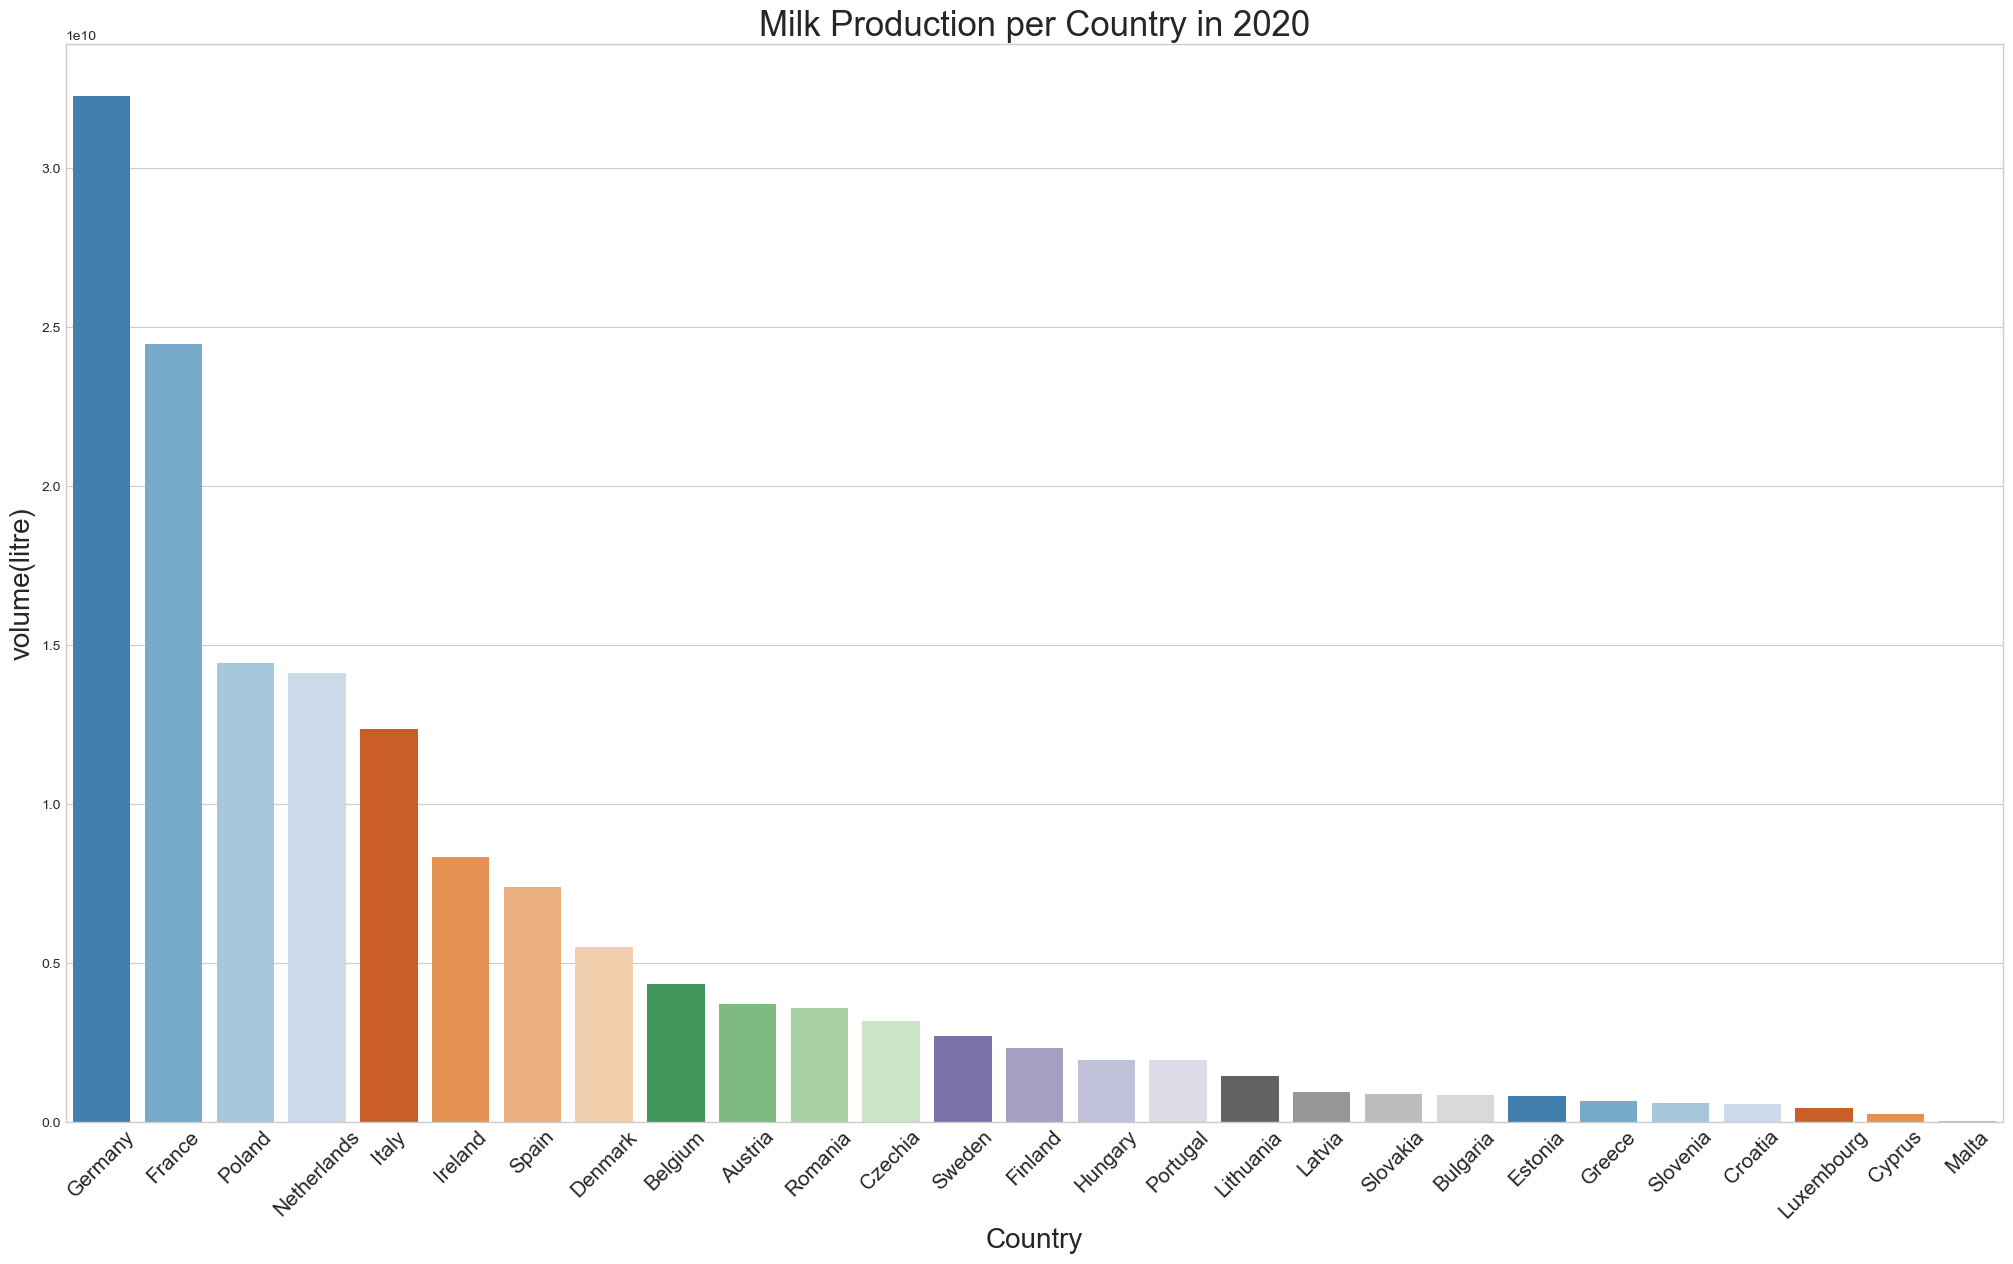

In [44]:
#plotting the milk production per country in 2020
plot_barplot('volume(litre)', 'Milk Production per Country in 2020')

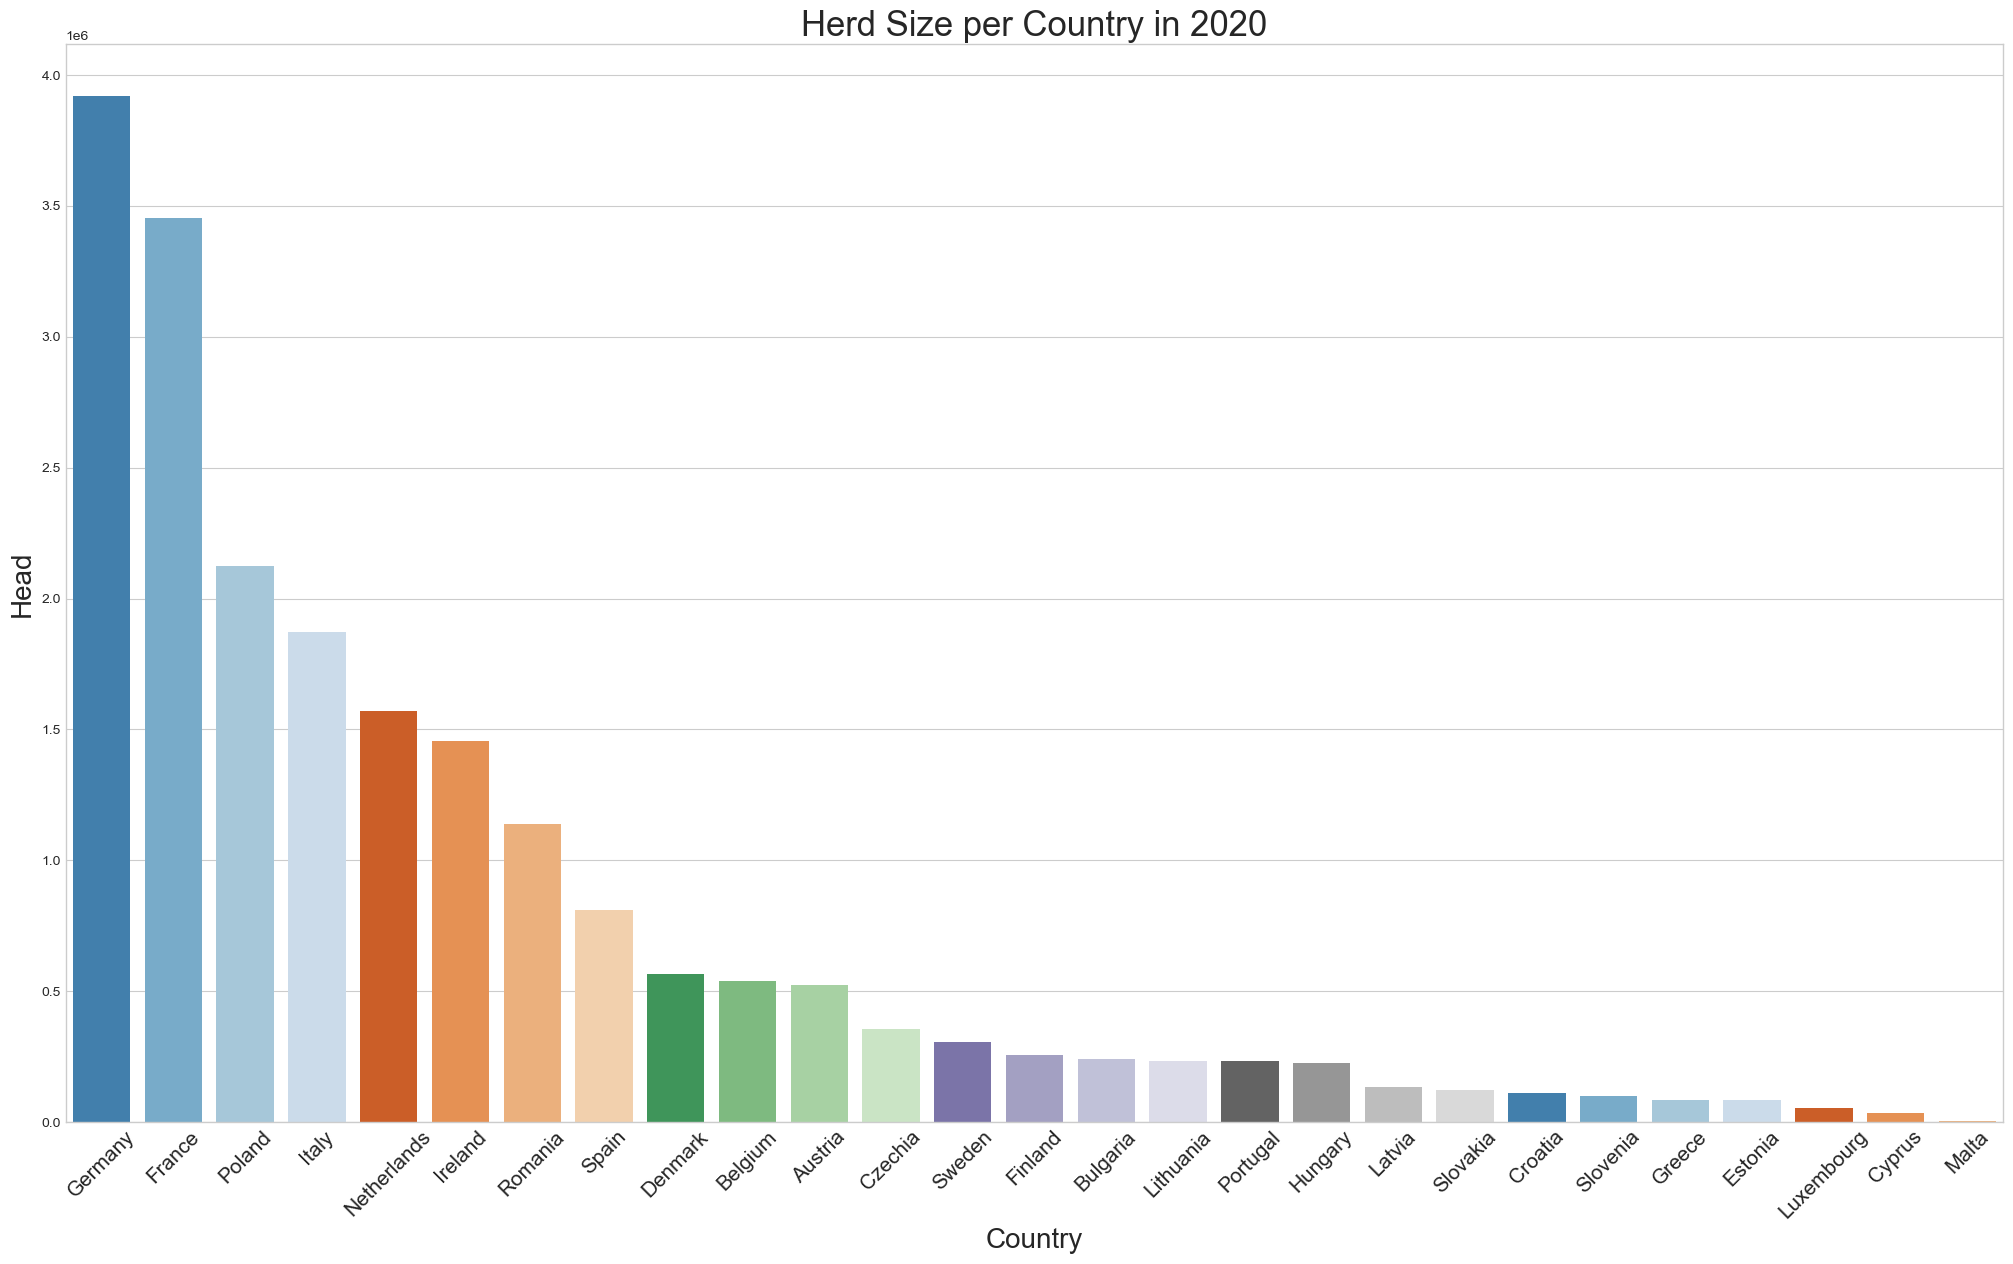

In [45]:
#and plotting the head size per country in 2020
plot_barplot('Head', 'Herd Size per Country in 2020')

Text(0, 0.5, 'Total milk production')

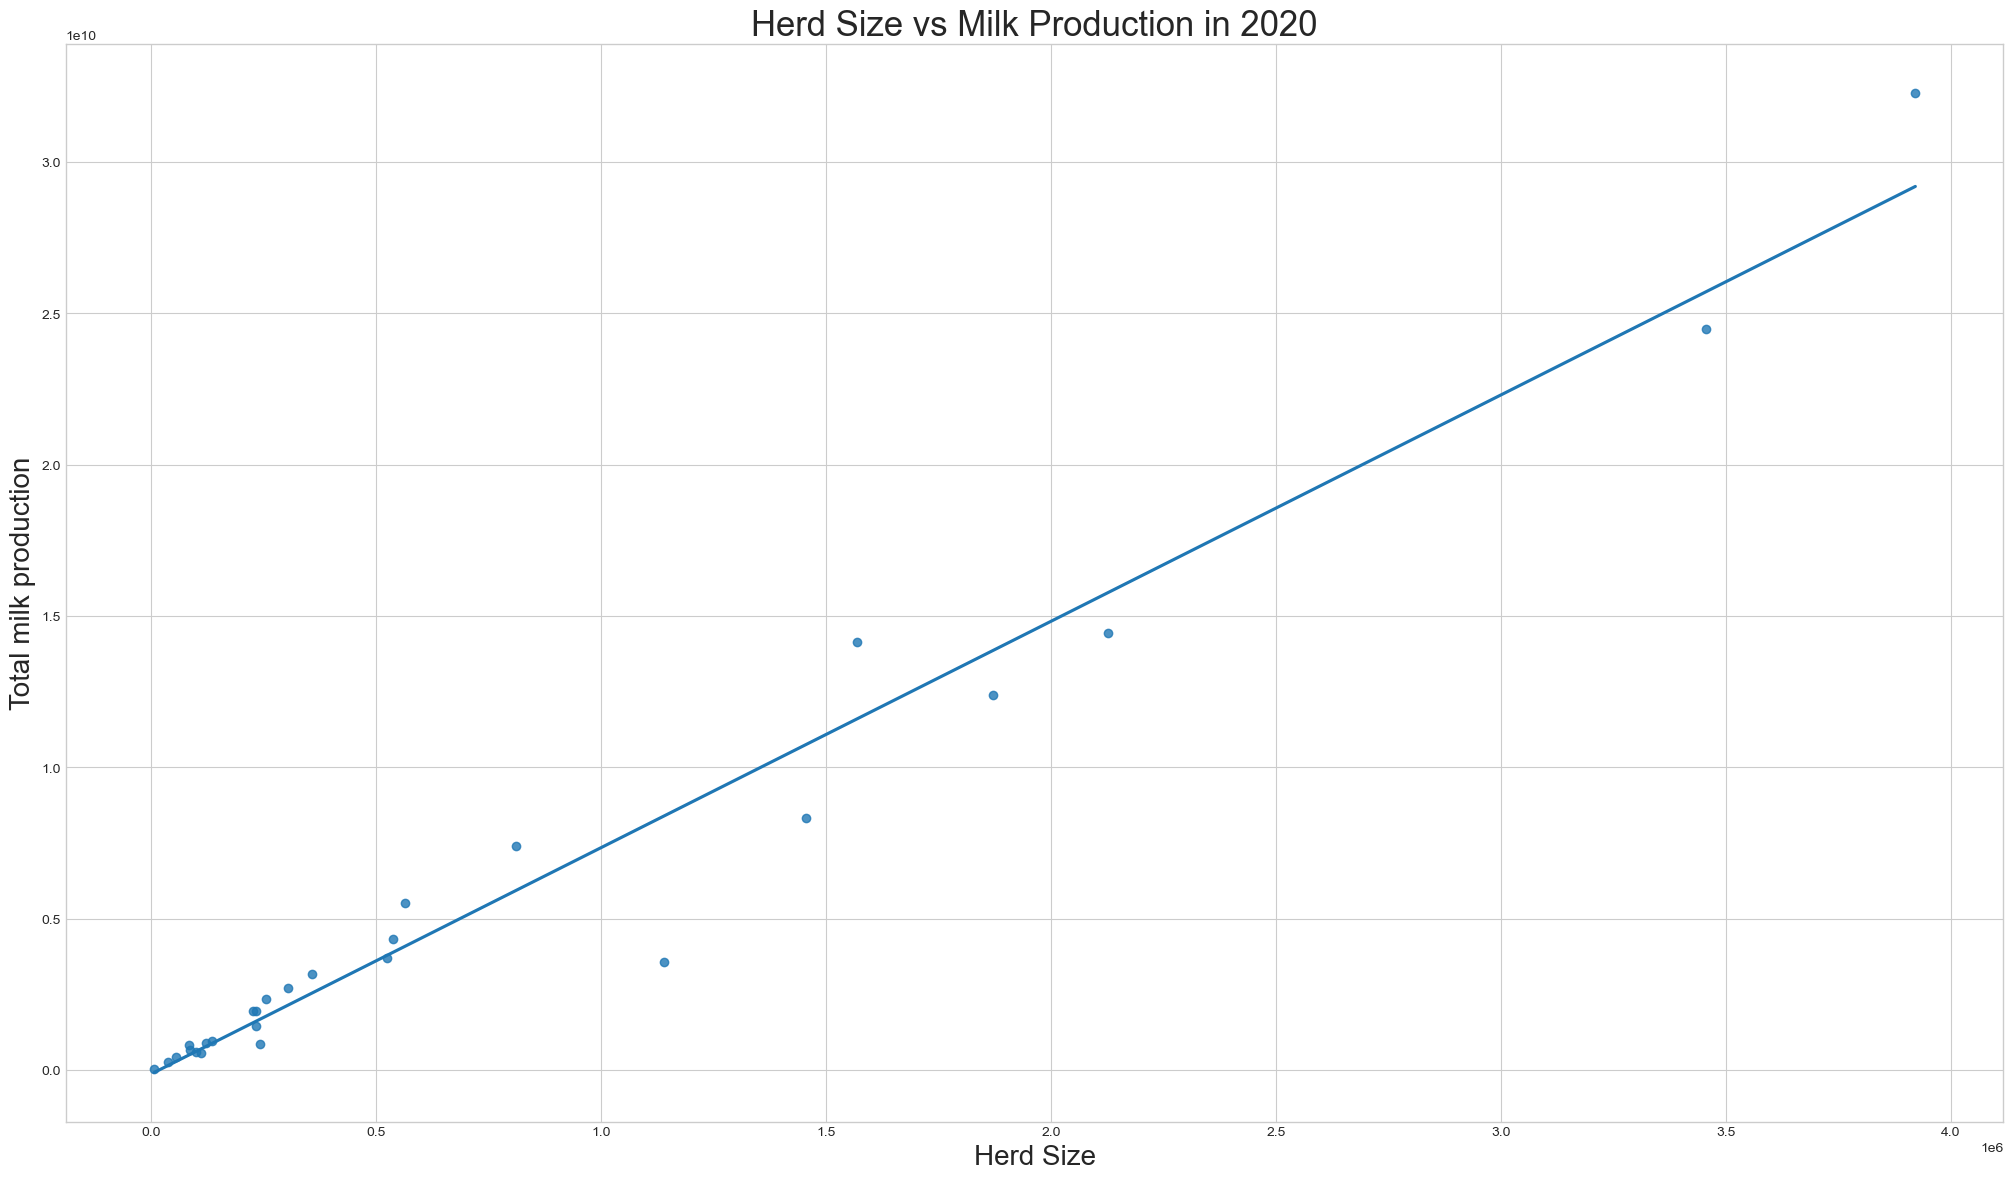

In [46]:
#we can see that the top 6 milk producing countries are the same as the top 6 herd size countries, 
#lets plot these against eachother to see if there is a correlation
sns.regplot(x='Head', y='volume(litre)', data=milk_eu_eda[(milk_eu_eda['Year'] == 2020 )], ci = None)
plt.title('Herd Size vs Milk Production in 2020', fontsize=25)
plt.xlabel('Herd Size', fontsize=20)
plt.ylabel('Total milk production', fontsize=20)


It looks like these values are pretty closely correlated. We will see the correlation coefficient soon. First im interested in seeing how the milk production and herd size changed over time. To prevent extremely messy & hard to read plots we will only consider the countries that the top 6 herd sizes and milk production in 2020

In [47]:
countries = milk_eu_eda[(milk_eu_eda['Year'] == 2020)].nlargest(6, 'Head')['Area']
years = milk_eu_eda['Year'].unique().tolist()
def trend_plot(df, measure, title, y_label):
    #defining a dictionary to store the data
    milk = {}
    #looping through the countries and years to get the data
    cmap = cm.tab20c(np.linspace(0, 1, len(countries)))
    for i, h in zip(countries, cmap):
        milk_volume = [] #creating a list to store the data
        year = []
        for j in years: 
            value = df[(df['Area'] == i) & (df['Year'] == j)][measure]  #getting the value
            if len(value) ==1:#checking if the value is present and length is 1
                milk_volume.append(value)
                year.append(j)

            else:
                pass #if not present, print error
        milk[i] = milk_volume #adding the data to the dictionary
        plt.plot(year, milk_volume, '--o', label=i, color = h)#plotting the data

    #styling the plot
    plt.legend(fontsize = 15)
    plt.title(title, fontsize=25)
    plt.xlabel('Year', fontsize=20)
    plt.ylabel(y_label, fontsize=20)

    plt.show()

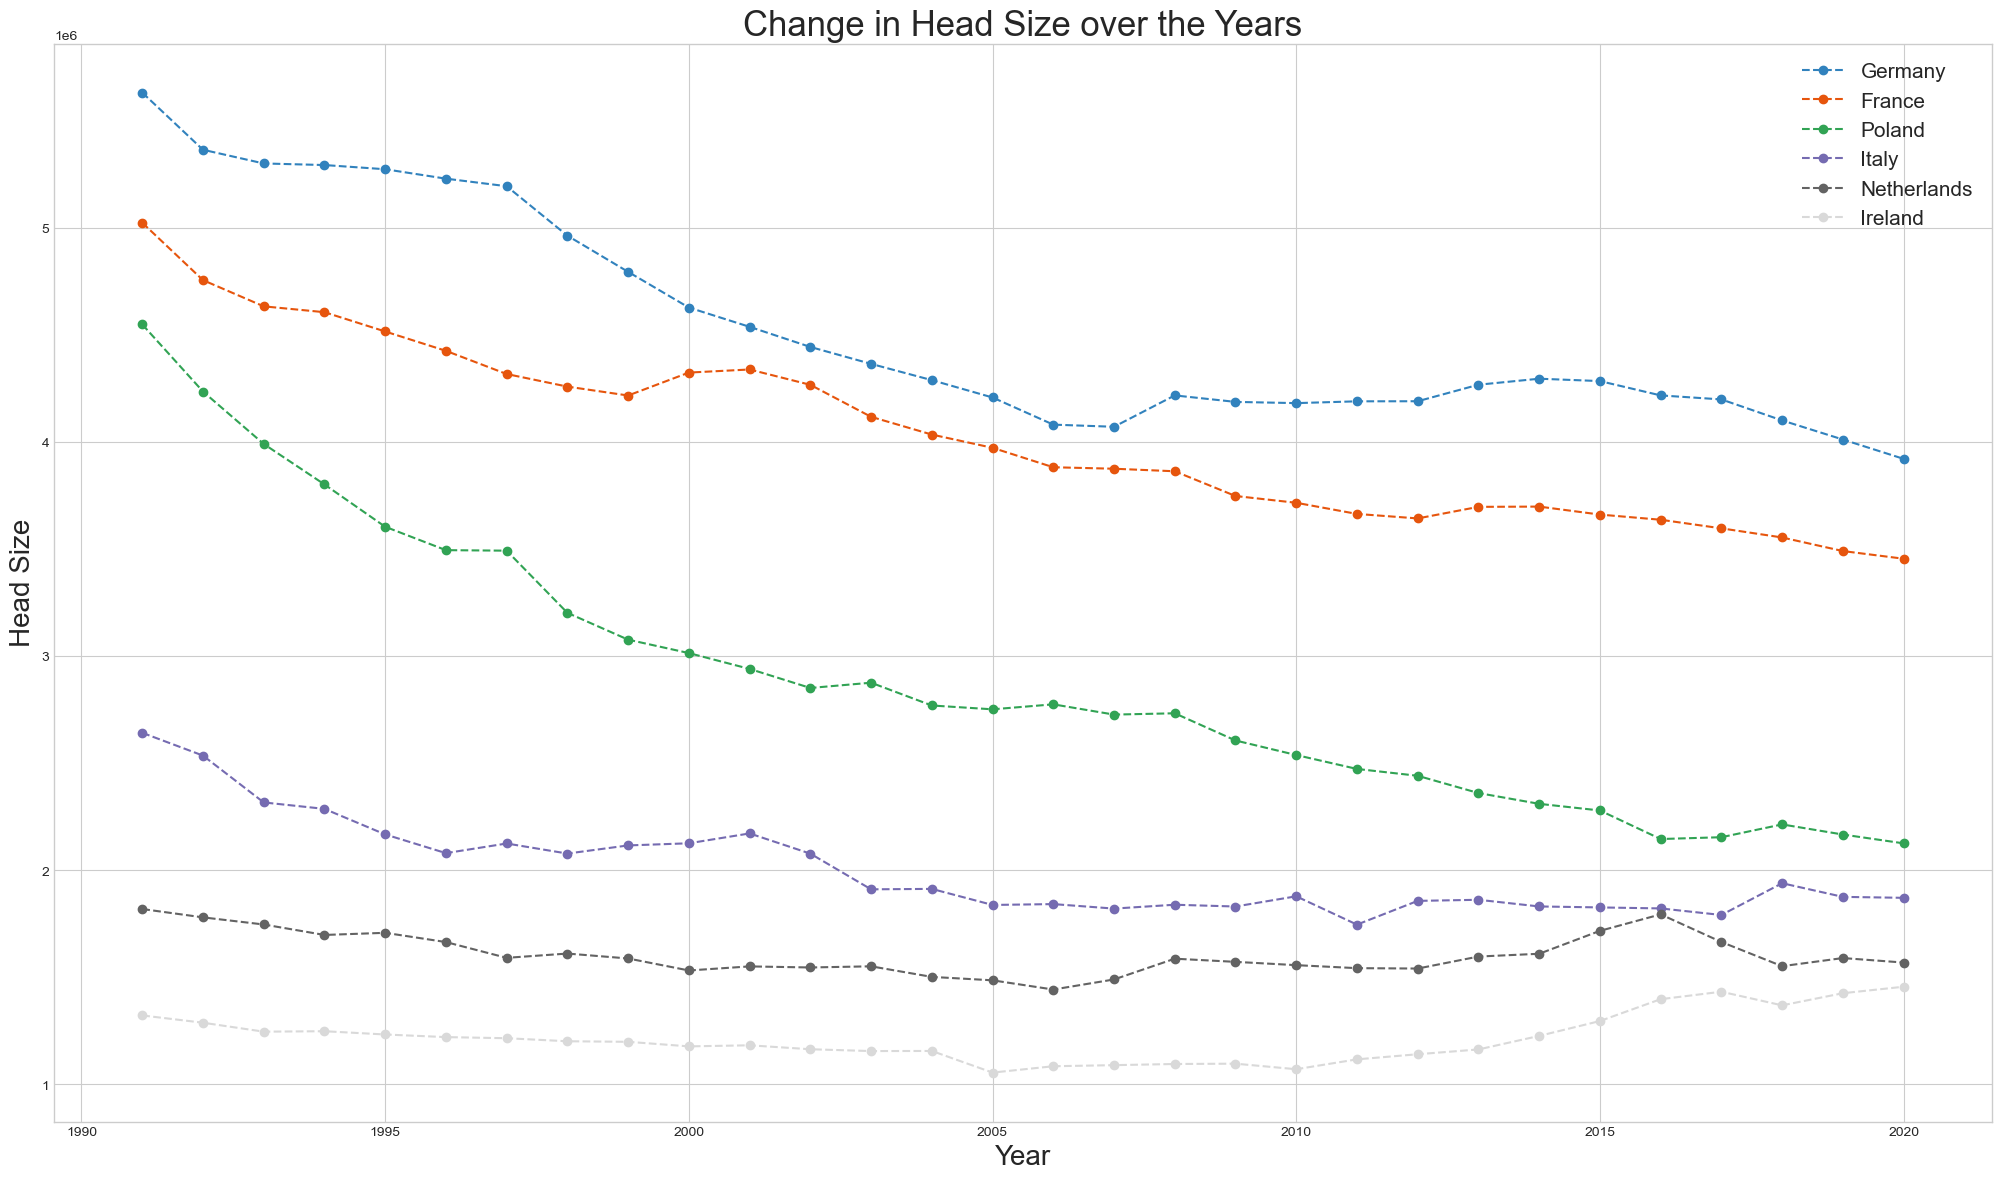

In [48]:
#plot the change in head size over the years for each country
trend_plot(milk_eu_eda, 'Head', 'Change in Head Size over the Years', 'Head Size')

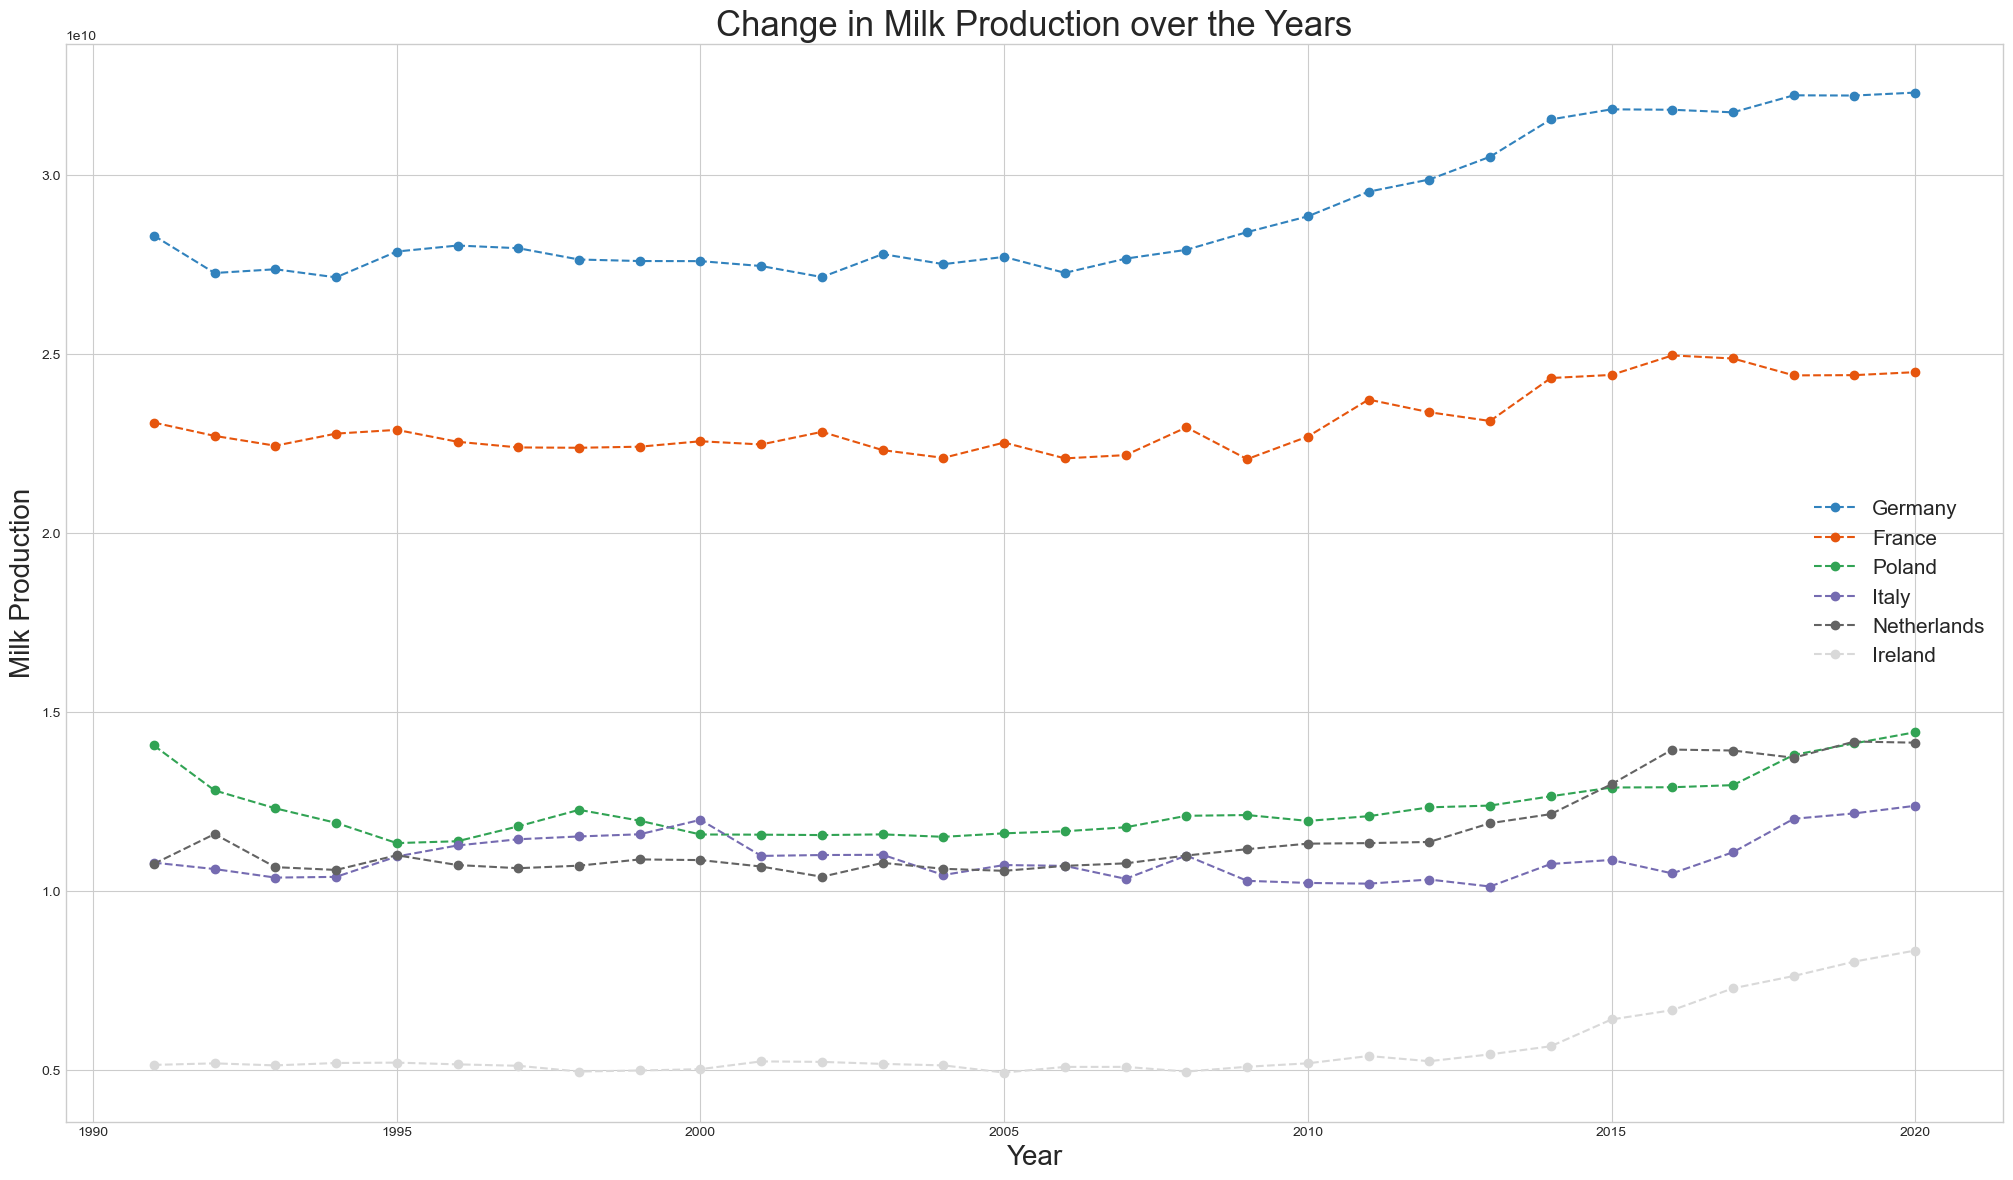

In [49]:
#and do the same for milk production
trend_plot(milk_eu_eda, 'volume(litre)', 'Change in Milk Production over the Years', 'Milk Production')

Thats interesting... while the milk production has remained constant over the years, or even increased... the herd size has decreased for many of the countries... Ireland is an exception though. Lets plot the change in milk per cow over the years

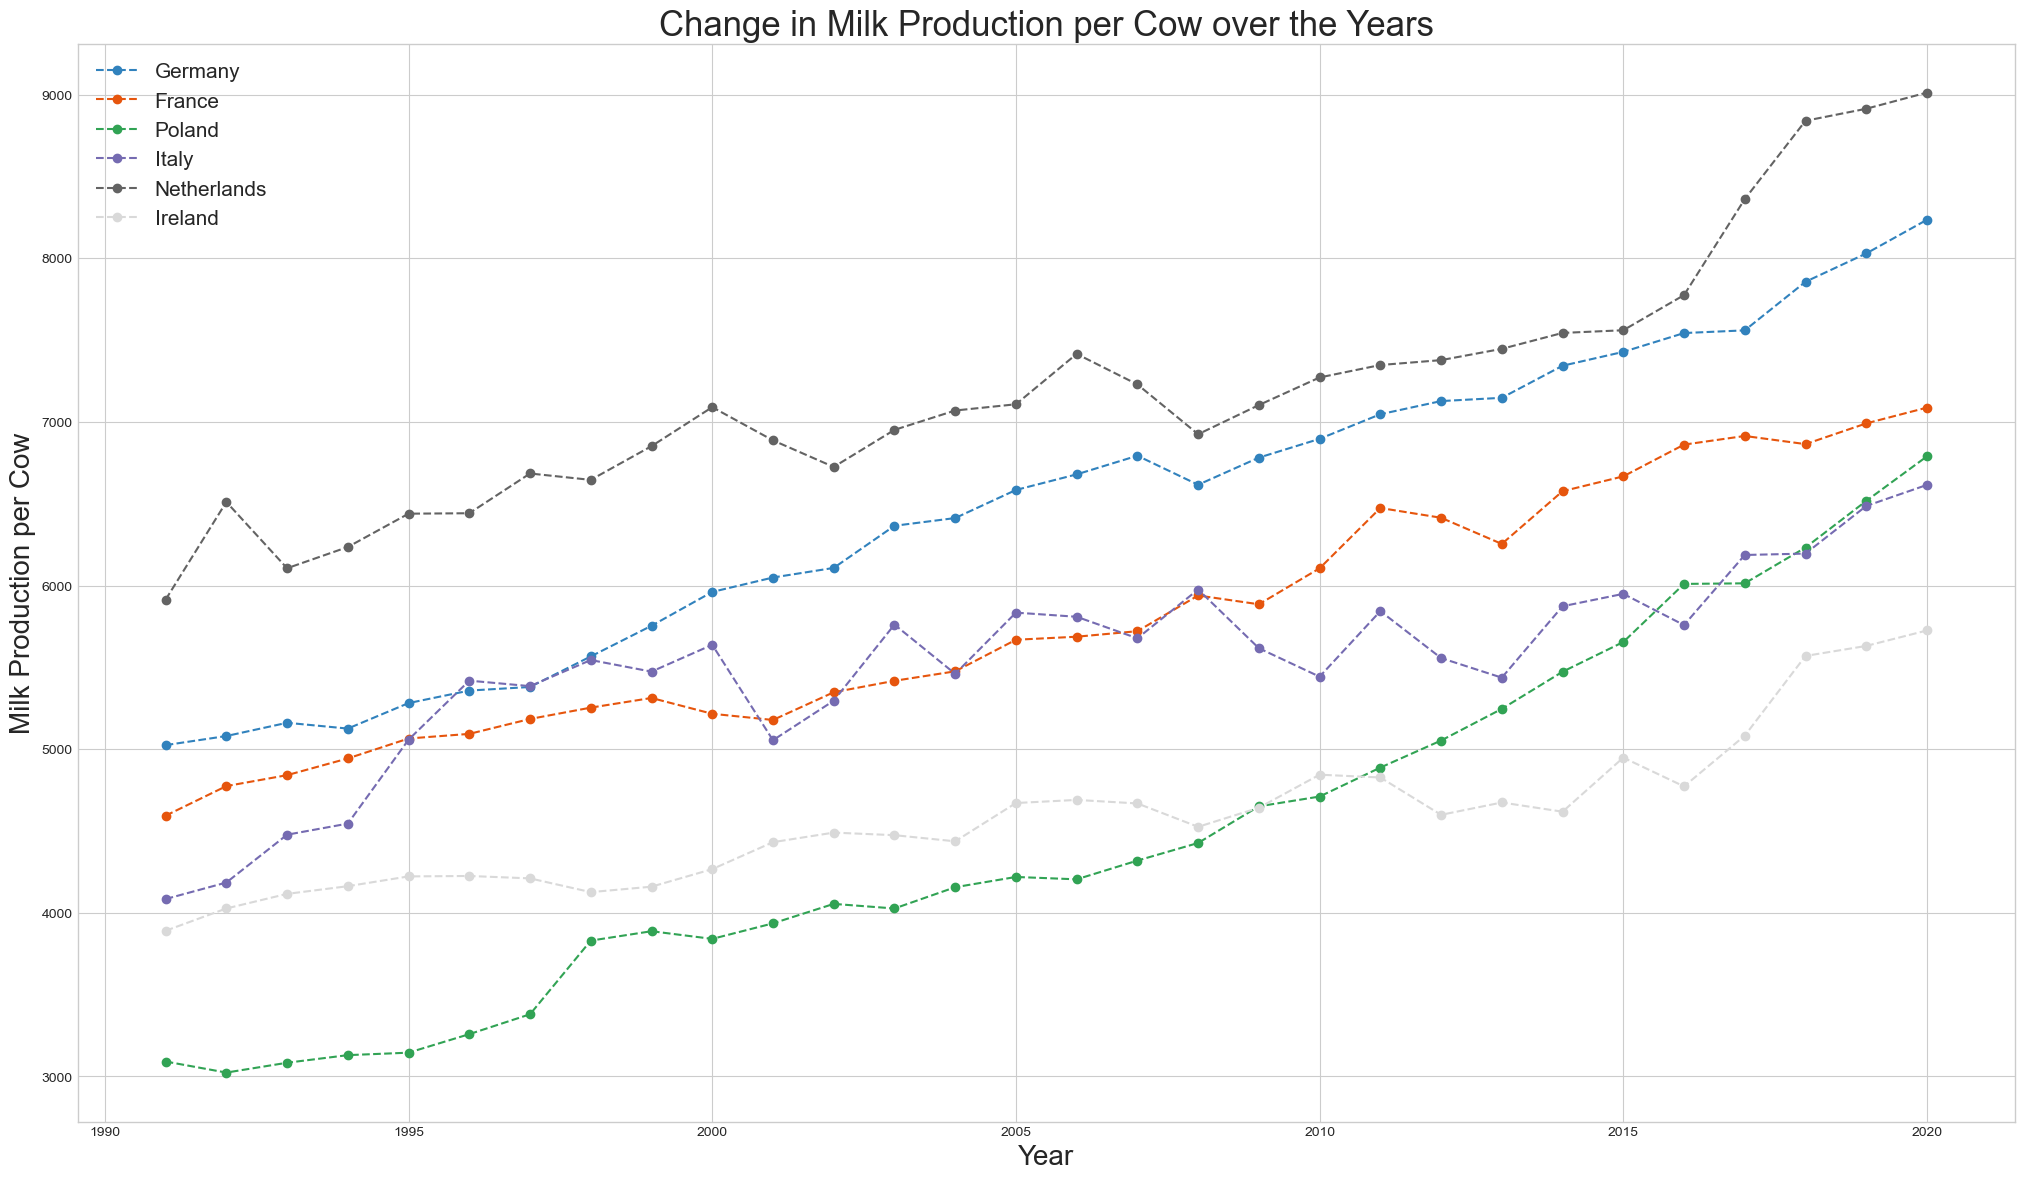

In [50]:
#plot the volume per cow over the years for each country
trend_plot(milk_eu_eda, 'volume/cow(litre)', 'Change in Milk Production per Cow over the Years', 'Milk Production per Cow')

Thats a bit mad, it appears that cows are producing more milk on average in 2020 than they were back in 1991... This really goes to show the efficacy of genetic breeding in agriculture. Out of interest lets find on average the multiple of milk production these days.

The average increase in milk production per cow is 1.67
The max increase in milk production per cow is 2.2 in Poland
The min increase in milk production per cow is 1.47 in Ireland


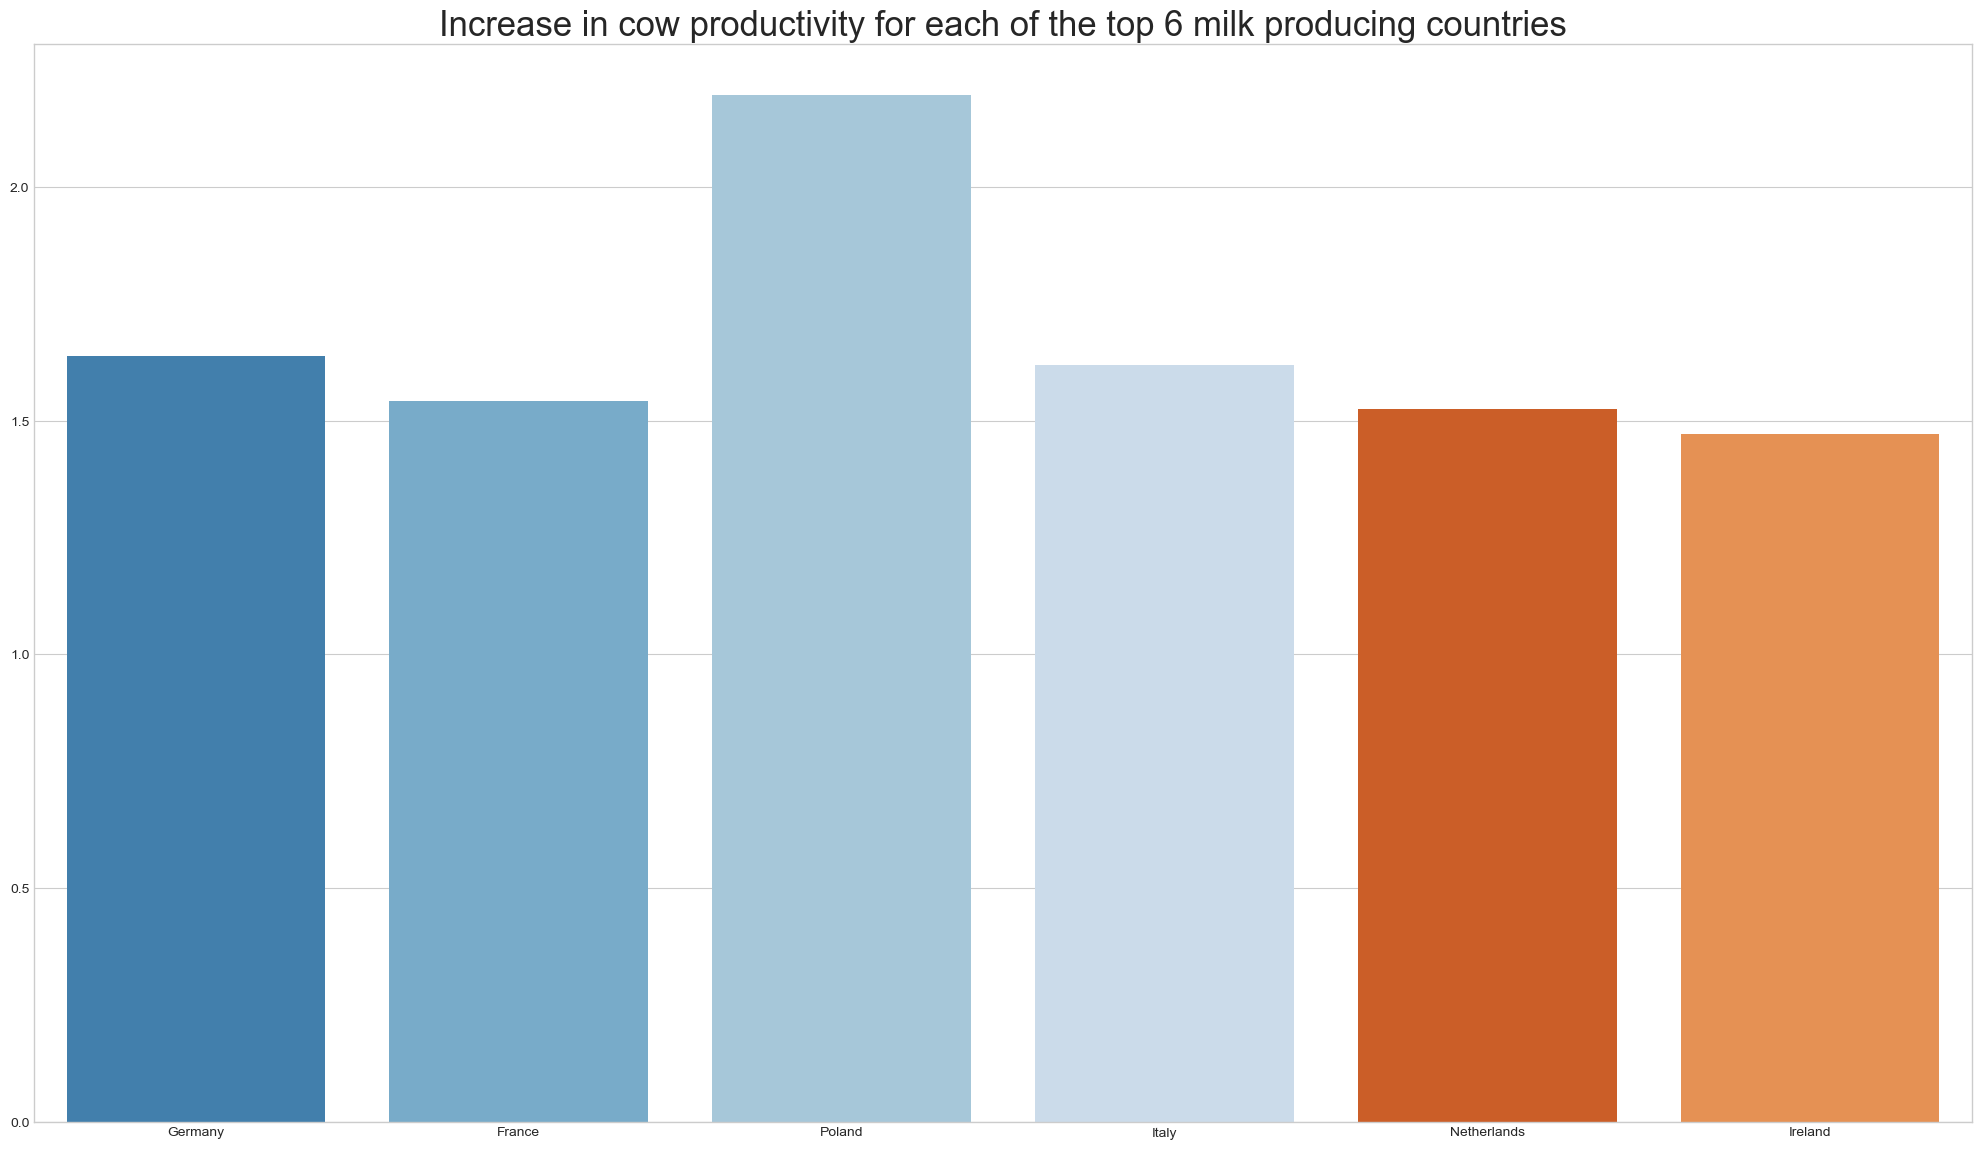

In [51]:
#this loop will calculate the ratio of milk production in 1991 to 2020 for each country
#and store it in a dictionary

milk_ratio = {}
for i in countries:
    milk_1991 = float(milk_eu_eda[(milk_eu_eda['Area'] == i) & (milk_eu_eda['Year'] == 1991)]['volume/cow(litre)'])
    milk_2020 = float(milk_eu_eda[(milk_eu_eda['Area'] == i) & (milk_eu_eda['Year'] == 2020)]['volume/cow(litre)'])
    ratio = milk_2020/milk_1991
    milk_ratio[i] = ratio

#plotting the ratio of milk production in 1991 to 2020 for each country in seaborn barplot
sns.barplot(x=list(milk_ratio.keys()), y=list(milk_ratio.values()), palette = color)
plt.title('Increase in cow productivity for each of the top 6 milk producing countries', fontsize=25)
#print the average increase in milk production ,ultiple
print('The average increase in milk production per cow is', round(np.mean(list(milk_ratio.values())), 2))
#print the max increase in milk production and country
print('The max increase in milk production per cow is', round(max(milk_ratio.values()), 2), 'in', max(milk_ratio, key=milk_ratio.get))
#print the min increase in milk production and country
print('The min increase in milk production per cow is', round(min(milk_ratio.values()), 2), 'in', min(milk_ratio, key=milk_ratio.get))


Over the last year a cows milk production has increased 1.67x on average, with a peak of 2.2x in poland & a minimum of 1.47x in ireland... It seems as though we need to rsmp up the genetic breeding, but for now lets just pretend out milk is better quality ha ha ?

Lets lok at the correlation between features using a seaborn heatmap

Text(0.5, 1.0, 'Correlation between attributes in our dataframe')

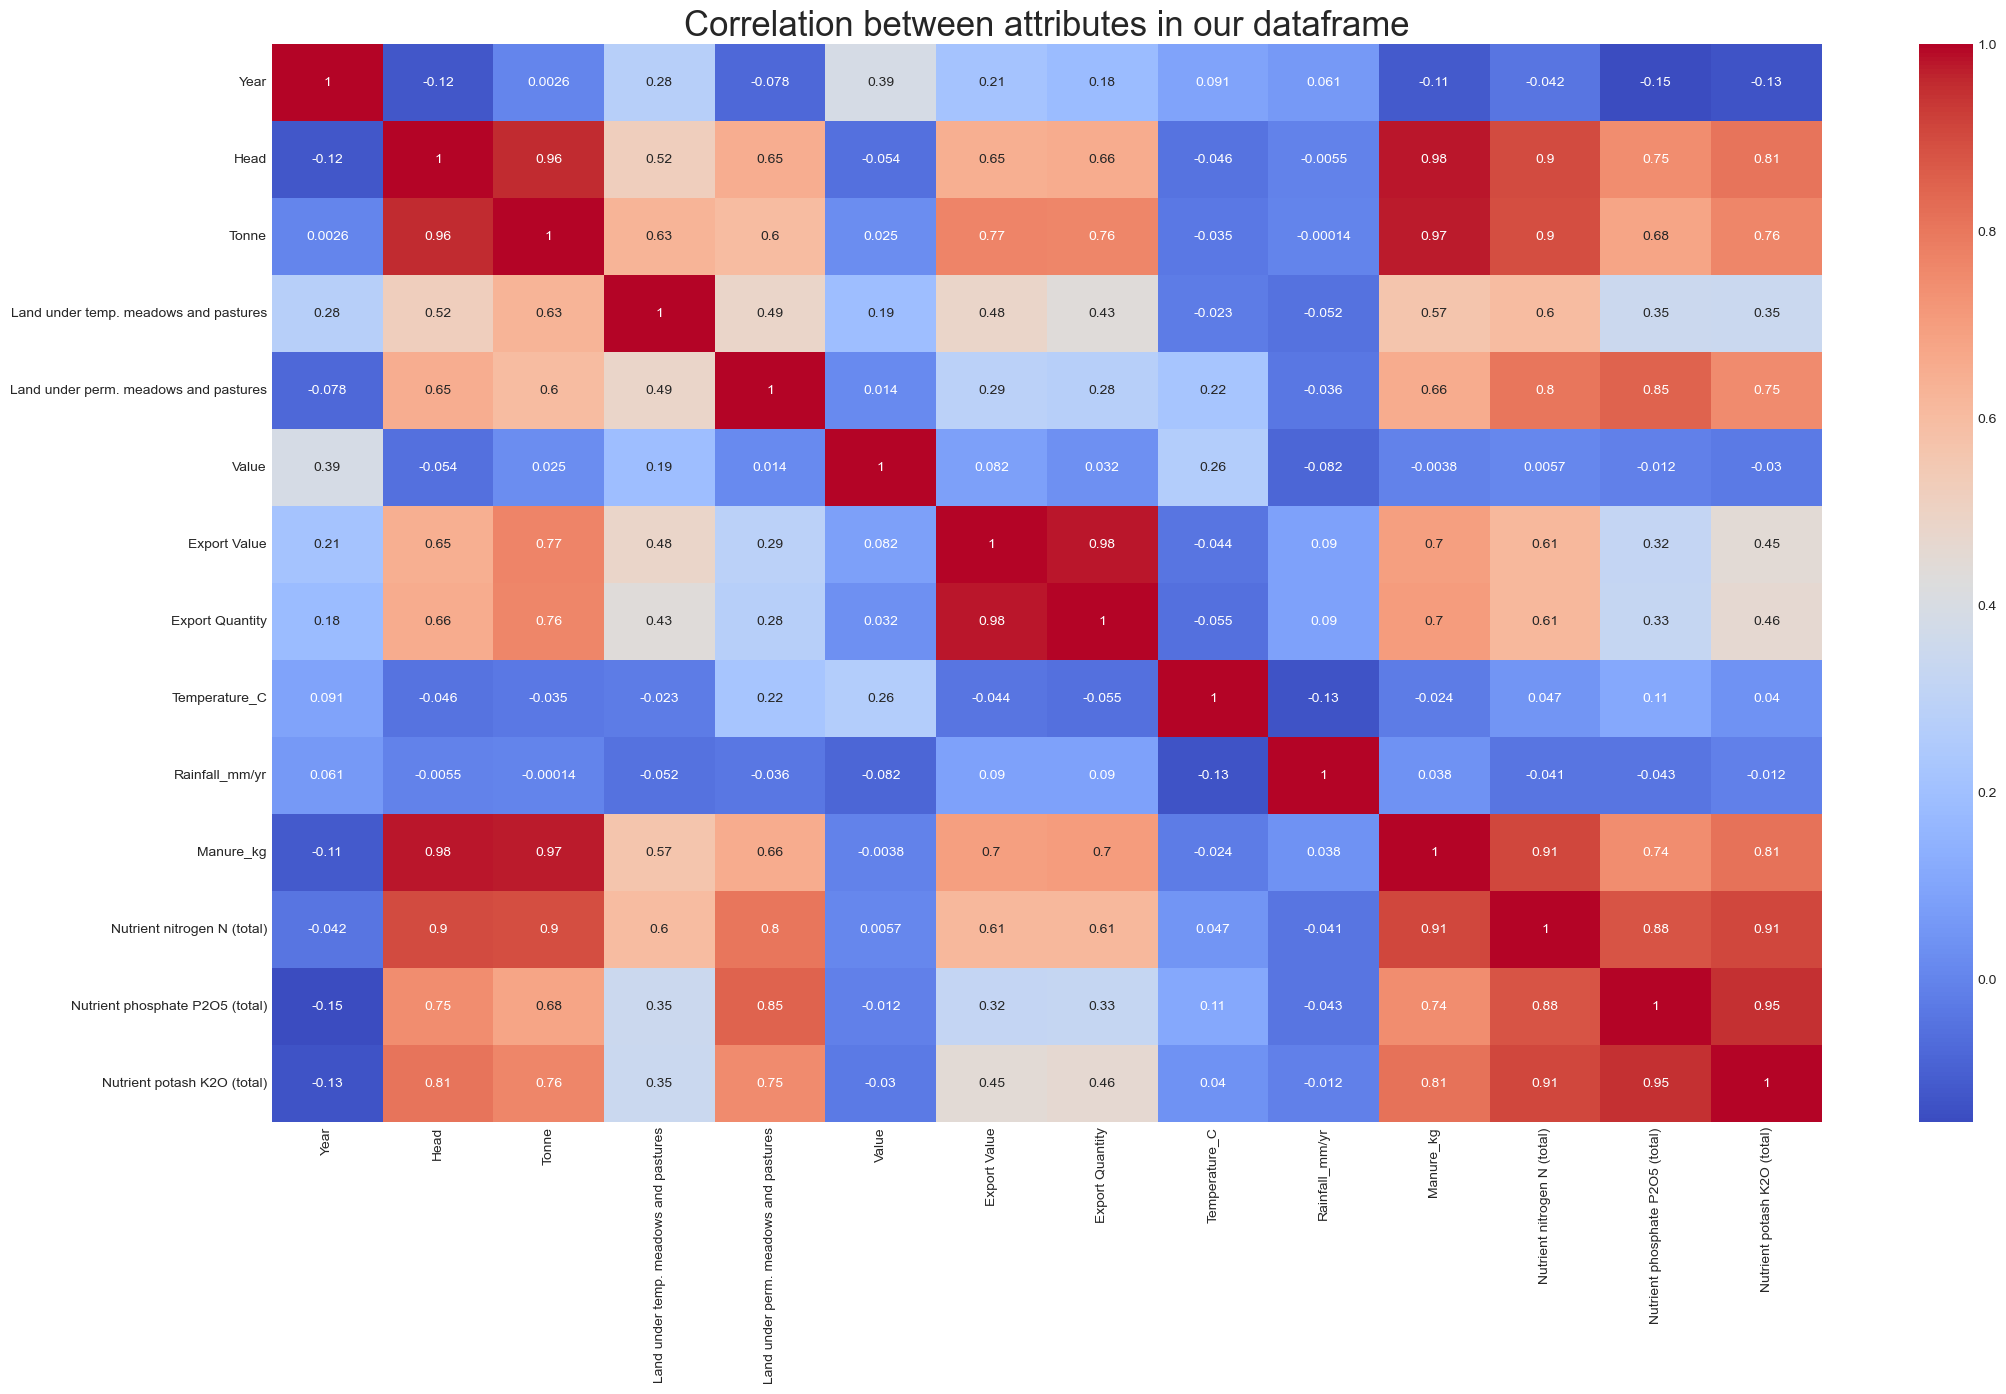

In [52]:
#correlation between columns and plotting as heatmap
sns.heatmap(milk_eu.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between attributes in our dataframe', fontsize=25)

In [53]:

#to allow for analysis we need to encode the Area column we will one hot encode it so the model doesnt mistake it for some sort of order and derive some correlation
milk_eu.head()

,Area,Year,Head,Tonne,Land under temp. meadows and pastures,Land under perm. meadows and pastures,Value,Export Value,Export Quantity,Temperature_C,Rainfall_mm/yr,Manure_kg,Nutrient nitrogen N (total),Nutrient phosphate P2O5 (total),Nutrient potash K2O (total)
0,Austria,1991,865392.0,3329700.0,0.0,1512.9,454.8,2543.0,3430.0,6.30,1080.48,1.819400e+07,132000.0,70400.0,86300.0
1,Austria,1992,841099.0,3286583.0,0.0,1507.0,499.6,3884.0,4879.0,7.45,1066.12,1.768327e+07,124000.0,65000.0,78000.0
2,Austria,1993,817935.0,3269622.0,0.0,1501.0,468.6,2992.0,3960.0,6.86,1049.61,1.719627e+07,120000.0,64000.0,78000.0
3,Austria,1994,804264.0,3278429.0,0.0,1495.1,478.9,2645.0,3356.0,8.11,1029.76,1.690885e+07,121000.0,56000.0,73000.0
4,Austria,1995,638339.0,2948170.0,0.0,1489.1,372.9,29680.0,63851.0,6.83,1144.60,1.342044e+07,125000.0,52000.0,60000.0


# 3) Machine learning applications

### a) Before we can go ahead with the machine learning we need to make a decision regarding our target variable. This will dictate the attributes that we keep for the features dataframe and the attribute that we set as the target

In [54]:
#encode the Area column
milk_eu.columns

Index(['Area', 'Year', 'Head', 'Tonne',
       'Land under temp. meadows and pastures',
       'Land under perm. meadows and pastures', 'Value', 'Export Value',
       'Export Quantity', 'Temperature_C', 'Rainfall_mm/yr', 'Manure_kg',
       'Nutrient nitrogen N (total)', 'Nutrient phosphate P2O5 (total)',
       'Nutrient potash K2O (total)'],
      dtype='object')

The target will be the price paid to the producers. This means that we will need to get rid of any attributes calculated from this column,
we will be keeping,

* year
* Head
* volume(litre)
* Land under temp pasture
* Land under perm pasture
* Temp_c
* Rain_mm/yr
* manure
* nitrogen
* potash
* phosphate
* % pasture
* price per litre ---> target
* exported volume
* exported value per litre usd
* keep all areas


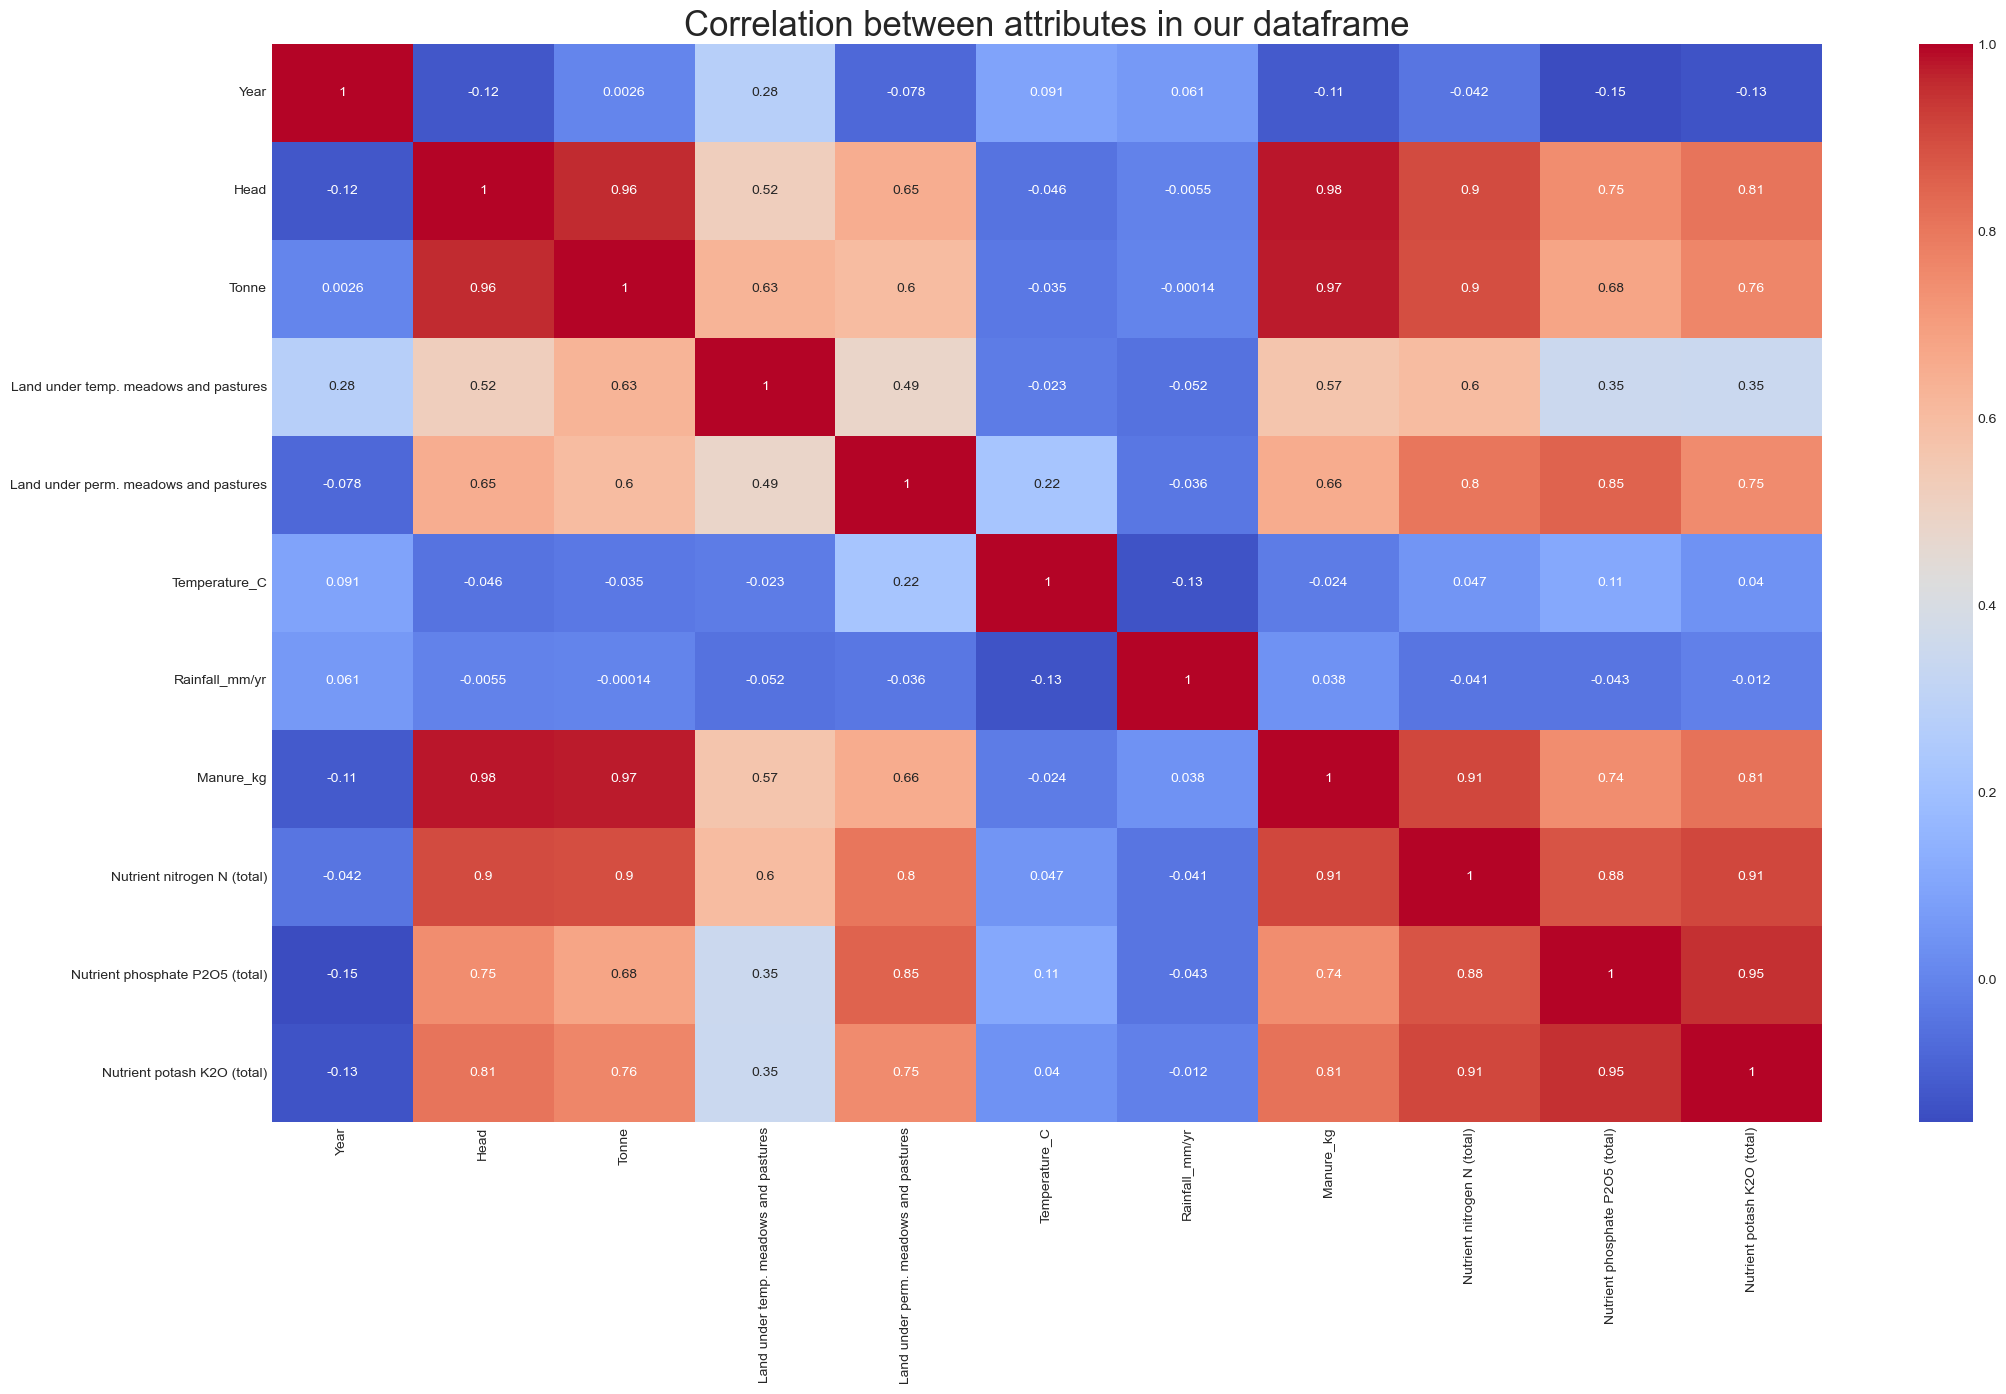

In [55]:
#feature selection
Y = milk_eu['Value']

#drop the columns we dont need
X = milk_eu.drop(['Value', 'Export Value', 'Export Quantity'], axis=1)
#correlation between columns and plotting as heatmap
sns.heatmap(X.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between attributes in our dataframe', fontsize=25)

#one hot encode the Area column
X = pd.get_dummies(X, columns=['Area'])







In [56]:
X.head()

,Year,Head,Tonne,Land under temp. meadows and pastures,Land under perm. meadows and pastures,Temperature_C,Rainfall_mm/yr,Manure_kg,Nutrient nitrogen N (total),Nutrient phosphate P2O5 (total),Nutrient potash K2O (total),Area_Austria,Area_Belgium,Area_Bulgaria,Area_Croatia,Area_Cyprus,Area_Czechia,Area_Denmark,Area_Estonia,Area_Finland,Area_France,Area_Germany,Area_Greece,Area_Hungary,Area_Ireland,Area_Italy,Area_Latvia,Area_Lithuania,Area_Luxembourg,Area_Malta,Area_Netherlands,Area_Poland,Area_Portugal,Area_Romania,Area_Slovakia,Area_Slovenia,Area_Spain,Area_Sweden
0,1991,865392.0,3329700.0,0.0,1512.9,6.30,1080.48,1.819400e+07,132000.0,70400.0,86300.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1992,841099.0,3286583.0,0.0,1507.0,7.45,1066.12,1.768327e+07,124000.0,65000.0,78000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1993,817935.0,3269622.0,0.0,1501.0,6.86,1049.61,1.719627e+07,120000.0,64000.0,78000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1994,804264.0,3278429.0,0.0,1495.1,8.11,1029.76,1.690885e+07,121000.0,56000.0,73000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1995,638339.0,2948170.0,0.0,1489.1,6.83,1144.60,1.342044e+07,125000.0,52000.0,60000.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [57]:
#splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.35, random_state=42)


#scaling the data#
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#pca
#from sklearn.decomposition import PCA
#pca = PCA(0.95)
#X_train = pca.fit_transform(X_train)
#X_test = pca.transform(X_test)




In [58]:
y_test

597    367.9
589    239.0
208    167.5
291    411.1
174    376.8
       ...  
314    416.9
426    496.2
473    123.2
176    353.9
535    547.5
Name: Value, Length: 275, dtype: float64

Fitting 10 folds for each of 1 candidates, totalling 10 fits
LinearRegression()


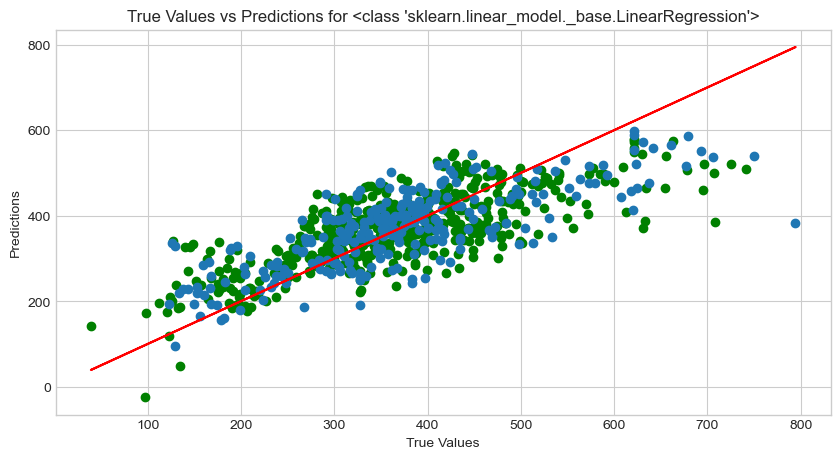

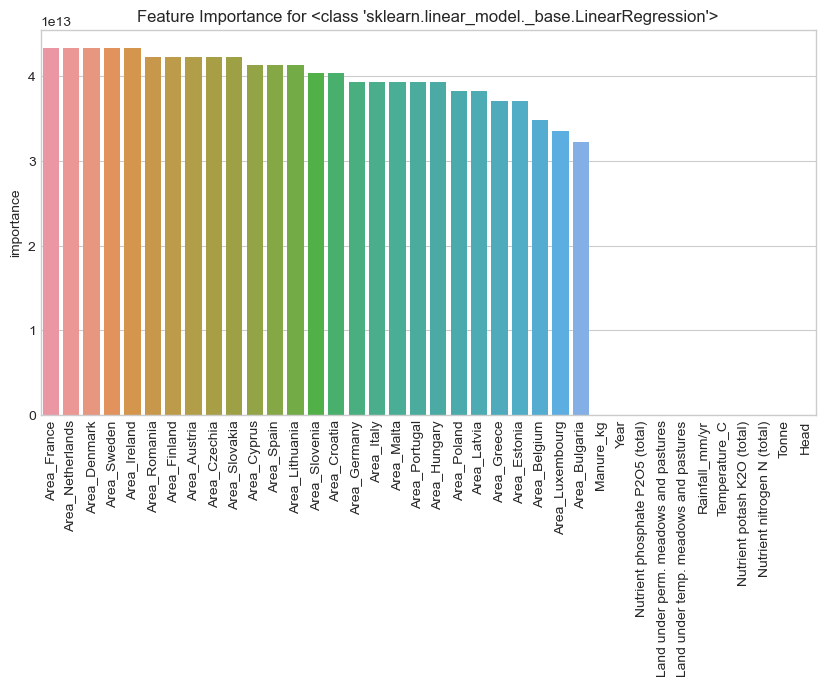

Fitting 10 folds for each of 600 candidates, totalling 6000 fits
Ridge(alpha=0.0, random_state=42, solver='sag')


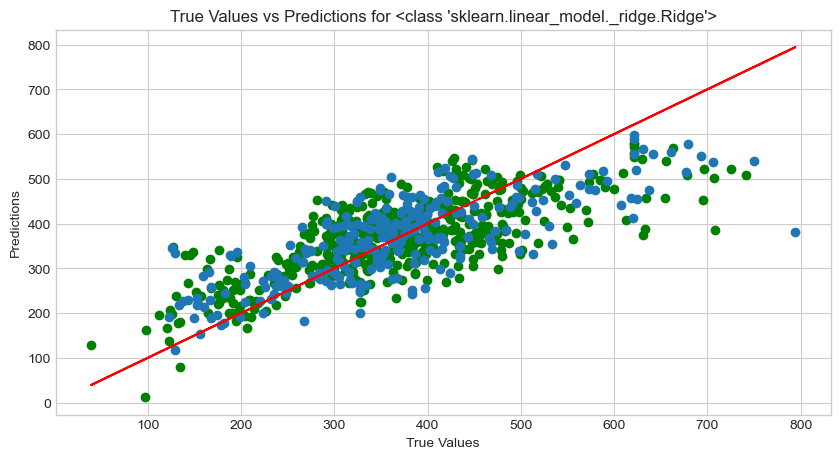

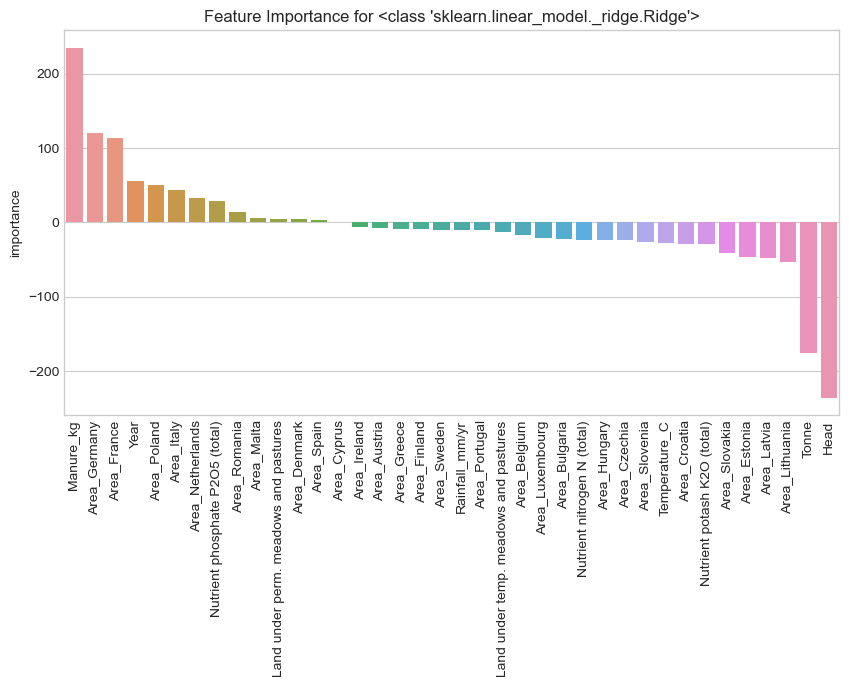

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Lasso(alpha=0.0, random_state=42)


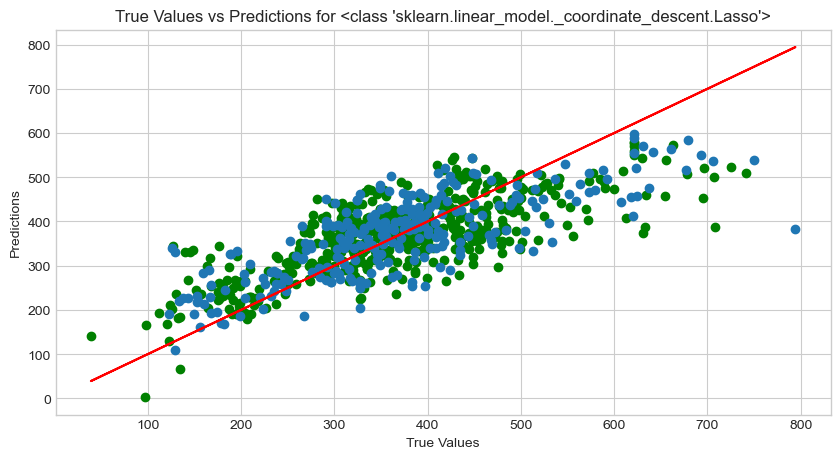

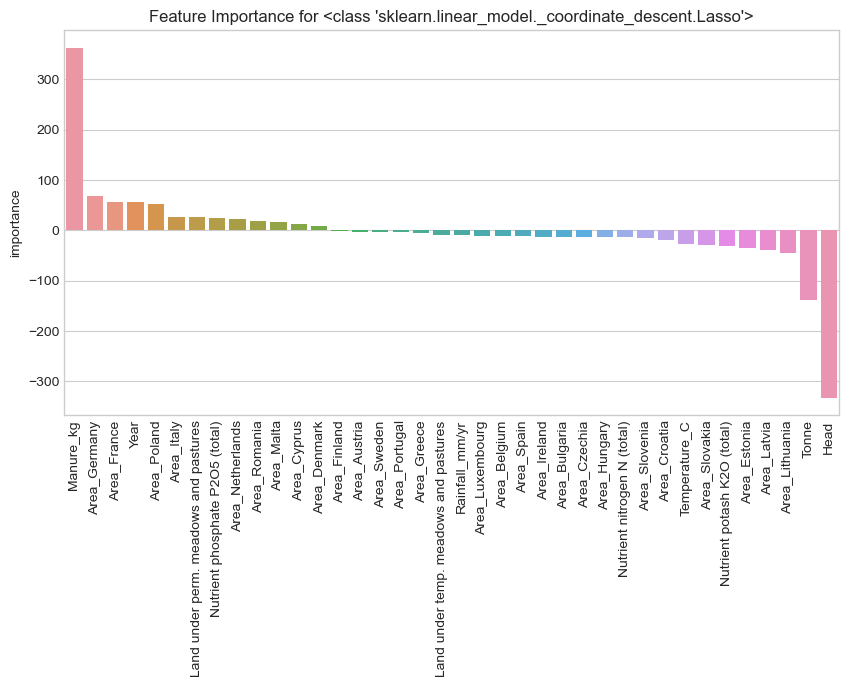

Fitting 10 folds for each of 80 candidates, totalling 800 fits
KNeighborsRegressor(algorithm='ball_tree', weights='distance')


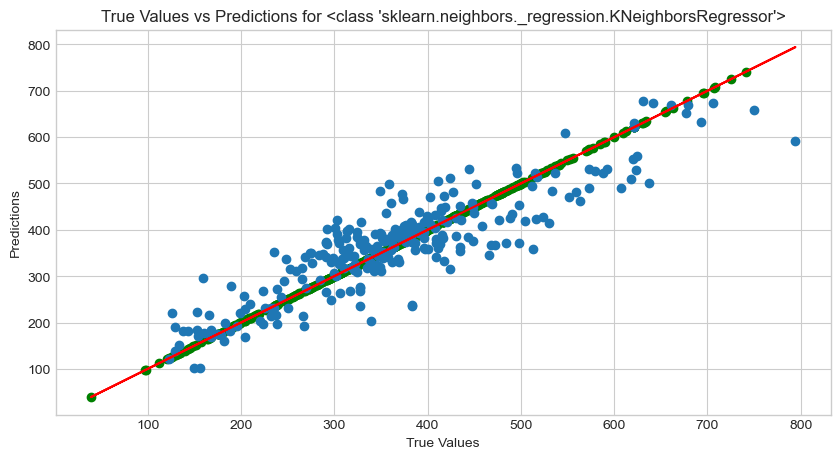

Shit outa luck!
Fitting 10 folds for each of 840 candidates, totalling 8400 fits
RandomForestRegressor(criterion='absolute_error', max_depth=9,
                      max_features=None, n_estimators=200, random_state=42)


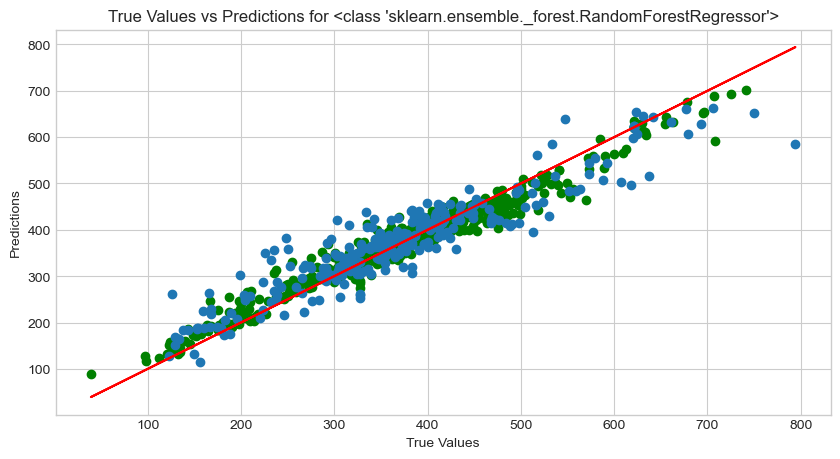

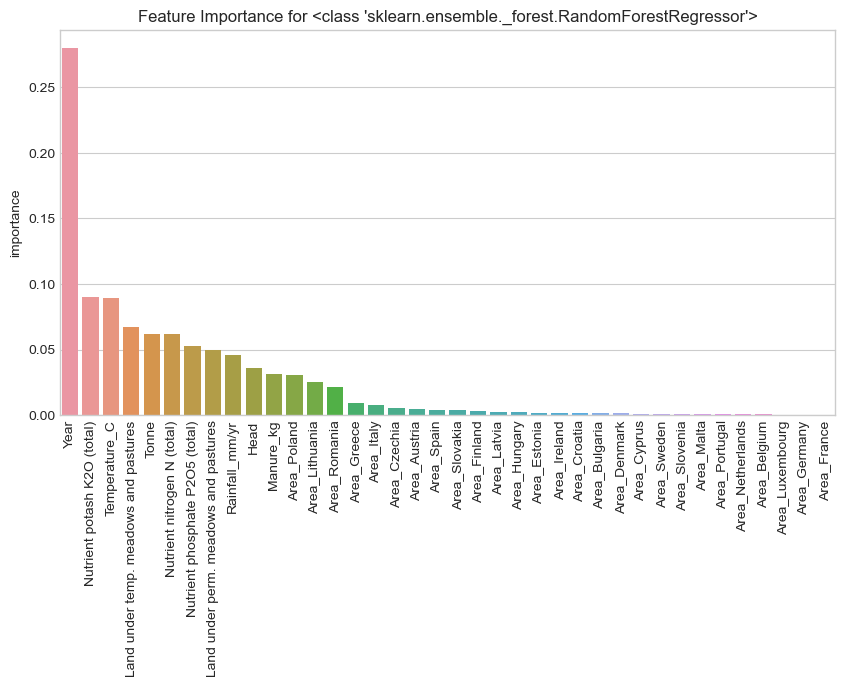

Fitting 10 folds for each of 30000 candidates, totalling 300000 fits
DecisionTreeRegressor(ccp_alpha=0.16326530612244897, criterion='absolute_error',
                      max_depth=14.285714285714286, random_state=42)


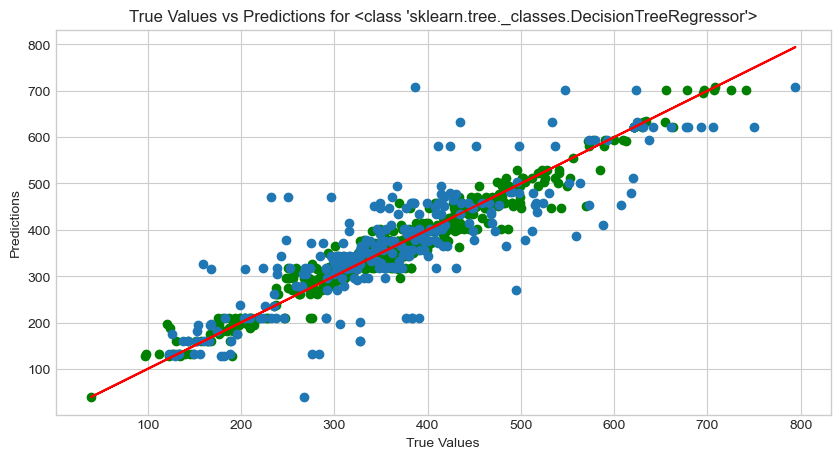

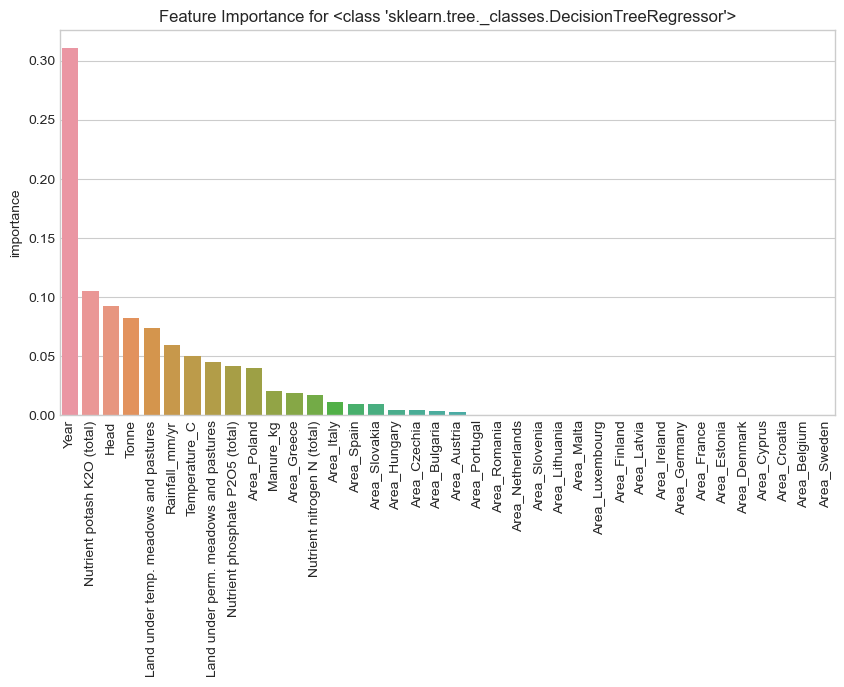

Fitting 10 folds for each of 5000 candidates, totalling 50000 fits
LinearSVR(C=2040816.3265306123, epsilon=85.71428571428572,
          loss='squared_epsilon_insensitive', random_state=42)


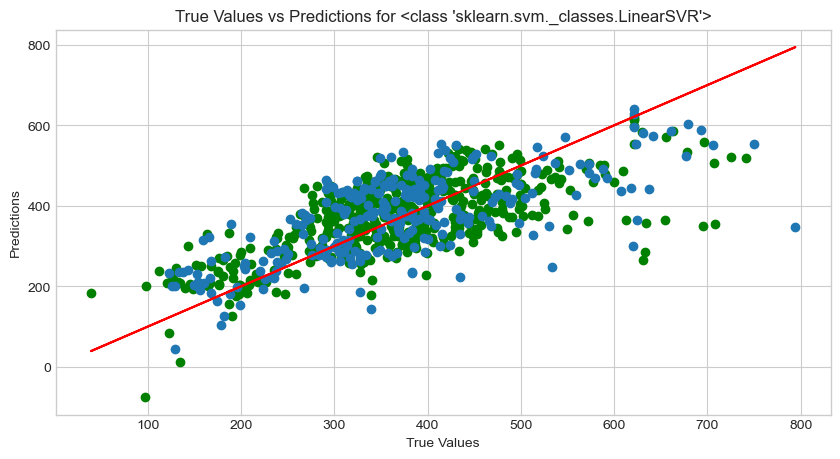

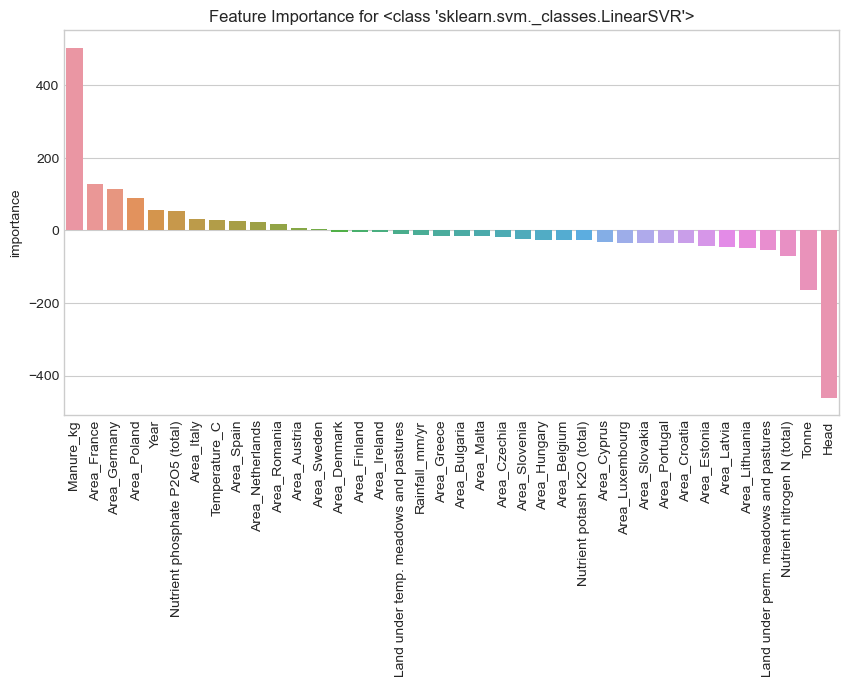

In [60]:
#completly rewrite the above code to work with randomised search cv
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
best_params = {}
results = {}
mape_score = {}
#dictionary of models
models = { 'Linear Regression': LinearRegression, 'Ridge Regression': Ridge, 'Lasso Regression': Lasso,
            'KNN Regression': KNeighborsRegressor, 'Random Forest Regression': RandomForestRegressor, 
            'Decision Tree Regression': DecisionTreeRegressor, 'Gradient Boosting Regression': GradientBoostingRegressor,
            'Linear SVR': LinearSVR}
#models = {'KNN Regression': KNeighborsRegressor}
#set random seed
np.random.seed(42)
for model in models.values():
    if model == LinearRegression:
        param_grid = {}
    elif model == Ridge:
        param_grid = {'alpha': np.linspace(0, 20, 50), 'random_state': [42], "fit_intercept": [True, False], "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'] }
    elif model == RandomForestRegressor:
        param_grid = {'n_estimators': np.arange(0, 700, 100), 'random_state': [42] , 'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'], 'max_features':['sqrt', 'log2', None], 'max_depth': np.arange(0, 10, 1) }
    elif model == DecisionTreeRegressor:
        param_grid = {'max_depth': np.linspace(0, 20, 50), 'random_state': [42], 'criterion': ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'], 'max_features':['sqrt', 'log2', None], 'ccp_alpha': np.linspace(0, 1, 50)}
    elif model == GradientBoostingRegressor:
        continue
        #param_grid = {'n_estimators': sp_randInt(0, 3000), 'random_state': [42], 'loss': ['squared_error', 'absolute_error', 'huber', 'quantile'], 'learning_rate':sp_randFloat(1, 1e6), 'criterion':['friedman_mse', 'squared_error'], 'max_features': ['auto', 'sqrt', 'log2'], 'ccp_alpha': sp_randFloat(0, 1e6)}
    elif model == LinearSVR:
        param_grid = {'C': np.linspace(0, 1e8, 50), 'random_state': [42], 'epsilon': np.linspace(0, 1e2, 50), 'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive']}
    elif model == Lasso:
        param_grid = {'alpha': np.linspace(0, 1e8, 50), 'random_state': [42]}
    elif model == KNeighborsRegressor:
        param_grid = {'n_neighbors': np.arange(1, 11, 1), 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
    
    grid = GridSearchCV(model(), param_grid, cv = 10, n_jobs = 12, verbose = 2)
    grid.fit(X_train, y_train)
    #predict
    grid_predictions = grid.predict(X_test)

    #best parameters
    best_params[model] = grid.best_estimator_
    print(grid.best_estimator_)

    #mean absolute percentage error
    ape_list = np.abs((grid_predictions-y_test)/y_test)*100
    #remove outliers using interquartile range

    #q1 = np.percentile(mape_list, 25)
    #q3 = np.percentile(mape_list, 75)
    #iqr = q3 - q1
    #lower_bound = q1 - (1.5 * iqr)
    #upper_bound = q3 + (1.5 * iqr)
    #if model == KNeighborsRegressor:
        #for i in mape_list:
          #  if i < lower_bound or i > upper_bound:
           #     mape_list.remove(i)
            #else:
             #   continue

    #else:
    #mape_list = mape_list[(mape_list > lower_bound) & (mape_list < upper_bound)]

    mape_score[model] = np.mean(ape_list)

    #r2 score
    r2 = r2_score(y_test, grid_predictions)
    results[model] = r2

    #plotting the results
    plt.figure(figsize=(10, 5))
    plt.scatter(y_train, grid.predict(X_train), color = 'green')
    plt.scatter(y_test, grid_predictions)
    plt.plot(Y, Y, color = 'red')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('True Values vs Predictions for {}'.format(model))
    plt.show()

    #feature importance for linear regression
    if model in [LinearRegression, Ridge, Lasso, LinearSVR]:
        feature_importance = pd.DataFrame(grid.best_estimator_.coef_, index = X.columns, columns = ['importance'])
        feature_importance = feature_importance.sort_values('importance', ascending = False)
        #plot using seaborn barplot
        plt.figure(figsize=(10, 5))
        sns.barplot(x = feature_importance.index, y = feature_importance['importance'])
        plt.xticks(rotation = 90)
        plt.title('Feature Importance for {}'.format(model))
        plt.show()
    #feature importance for KNeighborsRegressor
    elif model == KNeighborsRegressor:
        print('Shit outa luck!')
    #feature importance for other models
    else:
        feature_importance = pd.DataFrame(grid.best_estimator_.feature_importances_, index = X.columns, columns = ['importance'])
        feature_importance = feature_importance.sort_values('importance', ascending = False)
        #plot using seaborn barplot
        plt.figure(figsize=(10, 5))
        sns.barplot(x = feature_importance.index, y = feature_importance['importance'])
        plt.xticks(rotation = 90)
        plt.title('Feature Importance for {}'.format(model))
        plt.show()


In [67]:
#plot the model scores
model_compare = pd.DataFrame.from_dict(results, orient = 'index', columns=['R2 Score'])
#add new index column
model_compare['model'] = model_compare.index
model_compare.reset_index(drop=True, inplace=True)
#add best params
model_compare['best params'] = best_params.values()
#add mape
model_compare['MAPE'] = mape_score.values()
model_compare

,R2 Score,model,best params,MAPE
0,0.585577,<class 'sklearn.linear_model._base.LinearRegre...,LinearRegression(),19.006484
1,0.579370,<class 'sklearn.linear_model._ridge.Ridge'>,"Ridge(alpha=0.0, random_state=42, solver='sag')",19.008456
2,0.585141,<class 'sklearn.linear_model._coordinate_desce...,"Lasso(alpha=0.0, random_state=42)",18.937698
3,0.792013,<class 'sklearn.neighbors._regression.KNeighbo...,"KNeighborsRegressor(algorithm='ball_tree', wei...",12.836038
4,0.859740,<class 'sklearn.ensemble._forest.RandomForestR...,(DecisionTreeRegressor(criterion='absolute_err...,10.988009
5,0.659319,<class 'sklearn.tree._classes.DecisionTreeRegr...,DecisionTreeRegressor(ccp_alpha=0.163265306122...,14.837298
6,0.461775,<class 'sklearn.svm._classes.LinearSVR'>,"LinearSVR(C=2040816.3265306123, epsilon=85.714...",21.260259


In [68]:
model_compare.sort_values(by='R2 Score', ascending=False, inplace=True)

In [69]:
model_compare

,R2 Score,model,best params,MAPE
4,0.859740,<class 'sklearn.ensemble._forest.RandomForestR...,(DecisionTreeRegressor(criterion='absolute_err...,10.988009
3,0.792013,<class 'sklearn.neighbors._regression.KNeighbo...,"KNeighborsRegressor(algorithm='ball_tree', wei...",12.836038
5,0.659319,<class 'sklearn.tree._classes.DecisionTreeRegr...,DecisionTreeRegressor(ccp_alpha=0.163265306122...,14.837298
0,0.585577,<class 'sklearn.linear_model._base.LinearRegre...,LinearRegression(),19.006484
2,0.585141,<class 'sklearn.linear_model._coordinate_desce...,"Lasso(alpha=0.0, random_state=42)",18.937698
1,0.579370,<class 'sklearn.linear_model._ridge.Ridge'>,"Ridge(alpha=0.0, random_state=42, solver='sag')",19.008456
6,0.461775,<class 'sklearn.svm._classes.LinearSVR'>,"LinearSVR(C=2040816.3265306123, epsilon=85.714...",21.260259


In [64]:
results

{sklearn.linear_model._base.LinearRegression: 0.5855771022367225,
 sklearn.linear_model._ridge.Ridge: 0.5793699968269733,
 sklearn.linear_model._coordinate_descent.Lasso: 0.5851408177483405,
 sklearn.neighbors._regression.KNeighborsRegressor: 0.7920127098303135,
 sklearn.ensemble._forest.RandomForestRegressor: 0.859740351175349,
 sklearn.tree._classes.DecisionTreeRegressor: 0.6593193557417154,
 sklearn.svm._classes.LinearSVR: 0.4617752433214253}

In [65]:
test = [2017, 5043813, 56.22, 10086, 374.4, 160217, 193189.85, 12, 1000, 307813819.764, 443000, 304000, 146961.2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0	  ]

In [66]:
#save the data to a csv file
milk_eu.to_csv('milk_eu.csv', index=False)